# Open Payments Data Visualization
This notebook accompanies the report written by our team for the Fall 2021 Data Visualization course offered at Indiana Univerisity. In this notebook we will offer the code we utilized in order to make our visualizations as well as a look into the process we went through in order to improve them. 

To kick things off, we will need to download the dataset and run a few lines of utility code in order to make our lifes easier in the long run. A big issue we faced when trying to create this notebook is the sheer size of this dataset. Coming in at roughly 5.8 million rows and 75 columns, the dataset on it's own is around 3.3 GB. However pandas likes to use more RAM than that, and when run we've seen it try to use north of 20 GB when importing it. With colab ___only___ allocating 12 GB to the free addition, we have to read it into chunks and only bring in the columns we need for the next few visualizations. So while you are more than welcome to run this on your own, we'd like to warn you that it will take quite some time to run this notebook in its entirety.

The code used to read in chunks of the csv at a time isn't compatible with the default pandas version installed in colab, so it will need to be updated. After that we'll download the dataset. Downloading the dataset in collab will make a note about the iopub rate, but we don't care about the output for that, just that it gets downloaded.

__WARNING:__ This takes a ___long___ time to download, a ___really long___ time.

In [1]:
!pip install pandas==1.3.4

     |████████████████████████████████| 11.3 MB 9.0 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.4 which is incompatible.


In [2]:
%%bash
wget https://download.cms.gov/openpayments/PGYR20_P063021/OP_DTL_GNRL_PGYR2020_P06302021.csv

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [3]:
%%bash
wget https://download.cms.gov/openpayments/PGYR19_P063021/OP_DTL_GNRL_PGYR2019_P06302021.csv

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [4]:
%%bash
wget https://download.cms.gov/openpayments/PGYR18_P063021/OP_DTL_GNRL_PGYR2018_P06302021.csv

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
%%bash
wget https://download.cms.gov/openpayments/PGYR20_P063021/OP_DTL_RSRCH_PGYR2020_P06302021.csv

--2021-12-03 21:53:08--  https://download.cms.gov/openpayments/PGYR20_P063021/OP_DTL_RSRCH_PGYR2020_P06302021.csv
Resolving download.cms.gov (download.cms.gov)... 104.65.189.94, 2600:1409:d000:597::28a, 2600:1409:d000:599::28a
Connecting to download.cms.gov (download.cms.gov)|104.65.189.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503483925 (480M) [application/octet-stream]
Saving to: ‘OP_DTL_RSRCH_PGYR2020_P06302021.csv’

     0K .......... .......... .......... .......... ..........  0% 9.90M 48s
    50K .......... .......... .......... .......... ..........  0% 7.27M 57s
   100K .......... .......... .......... .......... ..........  0% 11.5M 52s
   150K .......... .......... .......... .......... ..........  0% 16.5M 46s
   200K .......... .......... .......... .......... ..........  0% 24.4M 41s
   250K .......... .......... .......... .......... ..........  0% 23.9M 37s
   300K .......... .......... .......... .......... ..........  0% 25.8M 35s
  

# Imports and Utility Code
As mentioned previously we need to be smart with our memory usage, and the function `df_from_csv_stream` helps us do just that. We simply pass in the columns we wish to use to it and we get back a DataFrame that includes only the specified columns. On top of that we change any columns that have under 100 unique values into categories to try to further help with memory usage. Below is the function definition along with all the import statements we need for this notebook. 

In [1]:
import os
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline
import numpy as np
import seaborn as sns
from matplotlib import rcParams
import plotly
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS

In [2]:
def df_from_csv_stream(cols, year=20, states=None):
  year_dict = {
      20: 'OP_DTL_GNRL_PGYR2020_P06302021.csv',
      19: 'OP_DTL_GNRL_PGYR2019_P06302021.csv',
      18: 'OP_DTL_GNRL_PGYR2018_P06302021.csv',
      0: 'OP_DTL_RSRCH_PGYR2020_P06302021.csv'
  }
  chunk_size=10**6
  df = pd.DataFrame(columns=cols)
  i = 0
  print(f'Processing file: {year_dict[year]}')

  with open(year_dict[year], 'r') as read:
    open_payments_columns = read.readline().split(',')
    read.close()

  with pd.read_csv(year_dict[year], chunksize=chunk_size, iterator=True, low_memory=False) as reader:
    for chunk in reader:
      chunk.columns = open_payments_columns
      if states != None:
        chunk = chunk[chunk['Recipient_State'].isin(states)]
      chunk = chunk[cols]
      df = df.append(chunk)
      i+=1
      print(f"Processed {i*chunk_size} rows.")

  for col in df.columns:
        if df[col].nunique() < 100:
          df[col] = df[col].astype('category')
  
  return df

# Initial data exploration using maps
One of the first visualizations our team did was to take a look at which states produce the most data in the dataset as well as the total paid out to each state. This was originally accomplished using the altair library as they provide a fairly simple method of producing choropleths, but later switched to plotly due to altair not behaving in the same manner on Google Colab.

## Data Prep

In [3]:
cols = ["Recipient_State", "Total_Amount_of_Payment_USDollars", "Teaching_Hospital_Name", "Teaching_Hospital_ID", "Physician_Profile_ID", "Date_of_Payment"]
df = df_from_csv_stream(cols)

Processing file: OP_DTL_GNRL_PGYR2020_P06302021.csv
Processed 1000000 rows.
Processed 2000000 rows.
Processed 3000000 rows.
Processed 4000000 rows.
Processed 5000000 rows.
Processed 6000000 rows.


In [4]:
state_desc_stats = df.groupby('Recipient_State')['Total_Amount_of_Payment_USDollars'].describe().sort_values('mean')
state_desc_stats['sum'] = df.groupby('Recipient_State')['Total_Amount_of_Payment_USDollars'].sum()
state_desc_stats = state_desc_stats.reset_index()

## Charting Count of Records for Every State

In [5]:
fig = px.choropleth(state_desc_stats, locations='Recipient_State',
                    locationmode="USA-states", color='count', scope="usa", color_continuous_scale=px.colors.sequential.Jet, custom_data=['count'], title='Total Count Per State', width=600, height=400)
fig.update_traces(hovertemplate = "%{customdata[0]:,}")
fig.show()

## Charting Average Spent Per Record

In [6]:
fig = px.choropleth(state_desc_stats, locations='Recipient_State',
                    locationmode="USA-states", color='mean', scope="usa", color_continuous_scale=px.colors.sequential.Jet, custom_data=['mean'], title='Average Spent Per Record', width=600, height=400)
fig.update_traces(hovertemplate = "$%{customdata[0]:,.2f}")
fig.show()

## Charting Total Spent Per State

In [7]:
fig = px.choropleth(state_desc_stats, locations='Recipient_State',
                    locationmode="USA-states", color='sum', scope="usa", color_continuous_scale=px.colors.sequential.Jet, custom_data=['sum'], title = 'Total Spent Per State', width=600, height=400)
fig.update_traces(hovertemplate = "$%{customdata[0]:,.2f}")
fig.show()

# Diving Deeper into the Top and Bottom States

In [8]:
top_10_states = state_desc_stats.nlargest(10, ['sum'])
bottom_10_states = state_desc_stats.nsmallest(10, ['sum'])

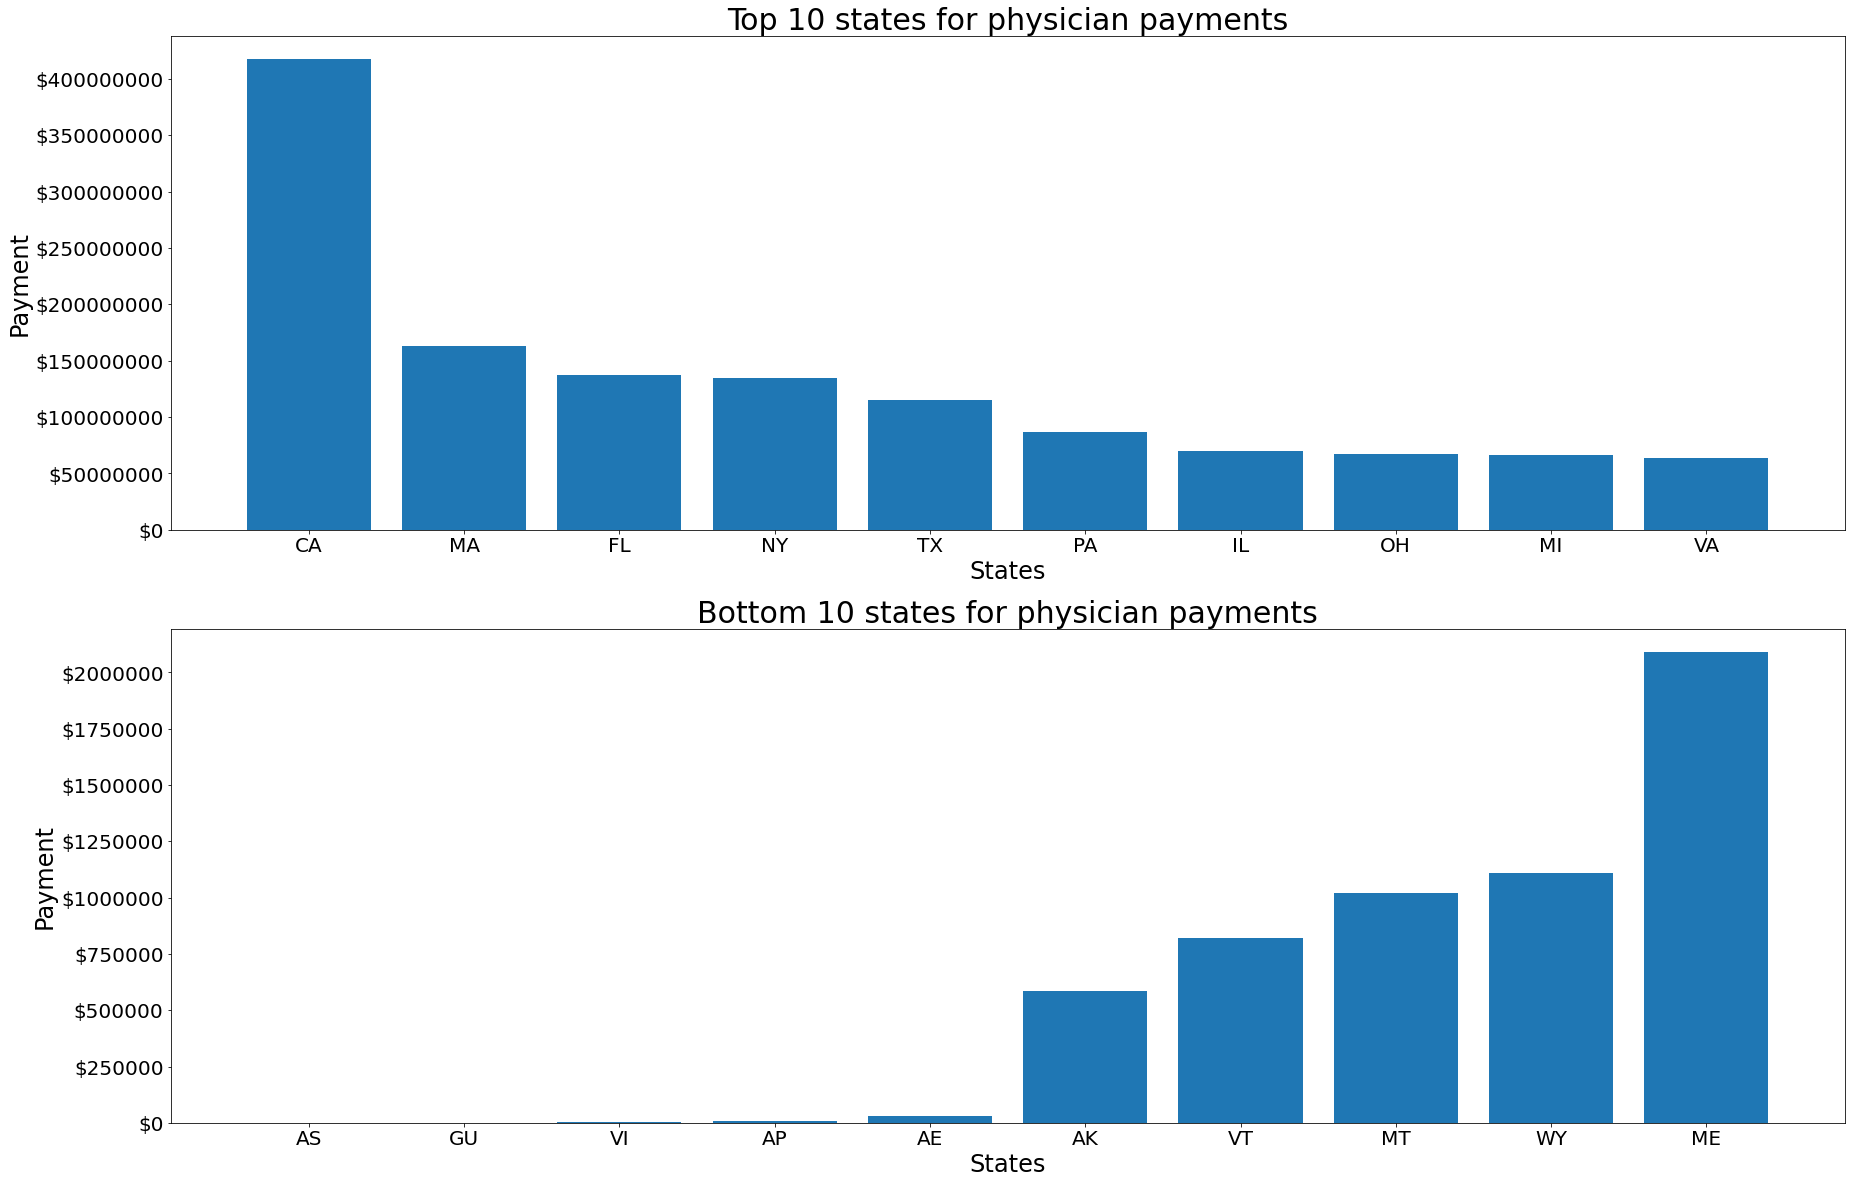

In [9]:
fig, axs = plt.subplots(2,figsize=(30,20))

axs[0].bar(top_10_states['Recipient_State'], top_10_states['sum'])
axs[0].set_title('Top 10 states for physician payments', fontsize=30)
axs[0].set_xlabel('States', fontsize=24)
axs[0].set_ylabel('Payment', fontsize=24) 
axs[0].set_xticklabels(top_10_states['Recipient_State'], fontsize=20)
axs[0].set_yticklabels(top_10_states['sum'], fontsize=20)
axs[0].yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))

axs[1].bar(bottom_10_states['Recipient_State'], bottom_10_states['sum'])
axs[1].set_xlabel('States', fontsize=24)
axs[1].set_ylabel('Payment', fontsize=24)
axs[1].set_title('Bottom 10 states for physician payments', fontsize=30)
axs[1].set_xticklabels(bottom_10_states['Recipient_State'], fontsize=20)
axs[1].set_yticklabels(bottom_10_states['sum'], fontsize=20)
axs[1].yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))

## Breaking the Data Down into Regions

In [10]:
Northeast_Region = ['CT', 'MA', 'ME', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT']
Midwest_Region = ['IA', 'IL', 'IN', 'KS', 'MI', 'MN', 'MO', 'ND', 'NE', 'OH', 'SD', 'WI']
West_Region = ['AK', 'AZ', 'CA', 'CO', 'HI', 'ID', 'MT', 'NM', 'NV', 'OR', 'UT', 'WA']
South_Region = ['AL', 'AR', 'DE', 'FL', 'GA', 'KY', 'LA', 'MD', 'MS', 'NC', 'OK', 'SC', 'TN', 'TX', 'VA', 'WV']

northeast_region = state_desc_stats[state_desc_stats['Recipient_State'].isin(Northeast_Region)]
west_region = state_desc_stats[state_desc_stats['Recipient_State'].isin(West_Region)]
south_region = state_desc_stats[state_desc_stats['Recipient_State'].isin(South_Region)]
midwest_region = state_desc_stats[state_desc_stats['Recipient_State'].isin(Midwest_Region)]

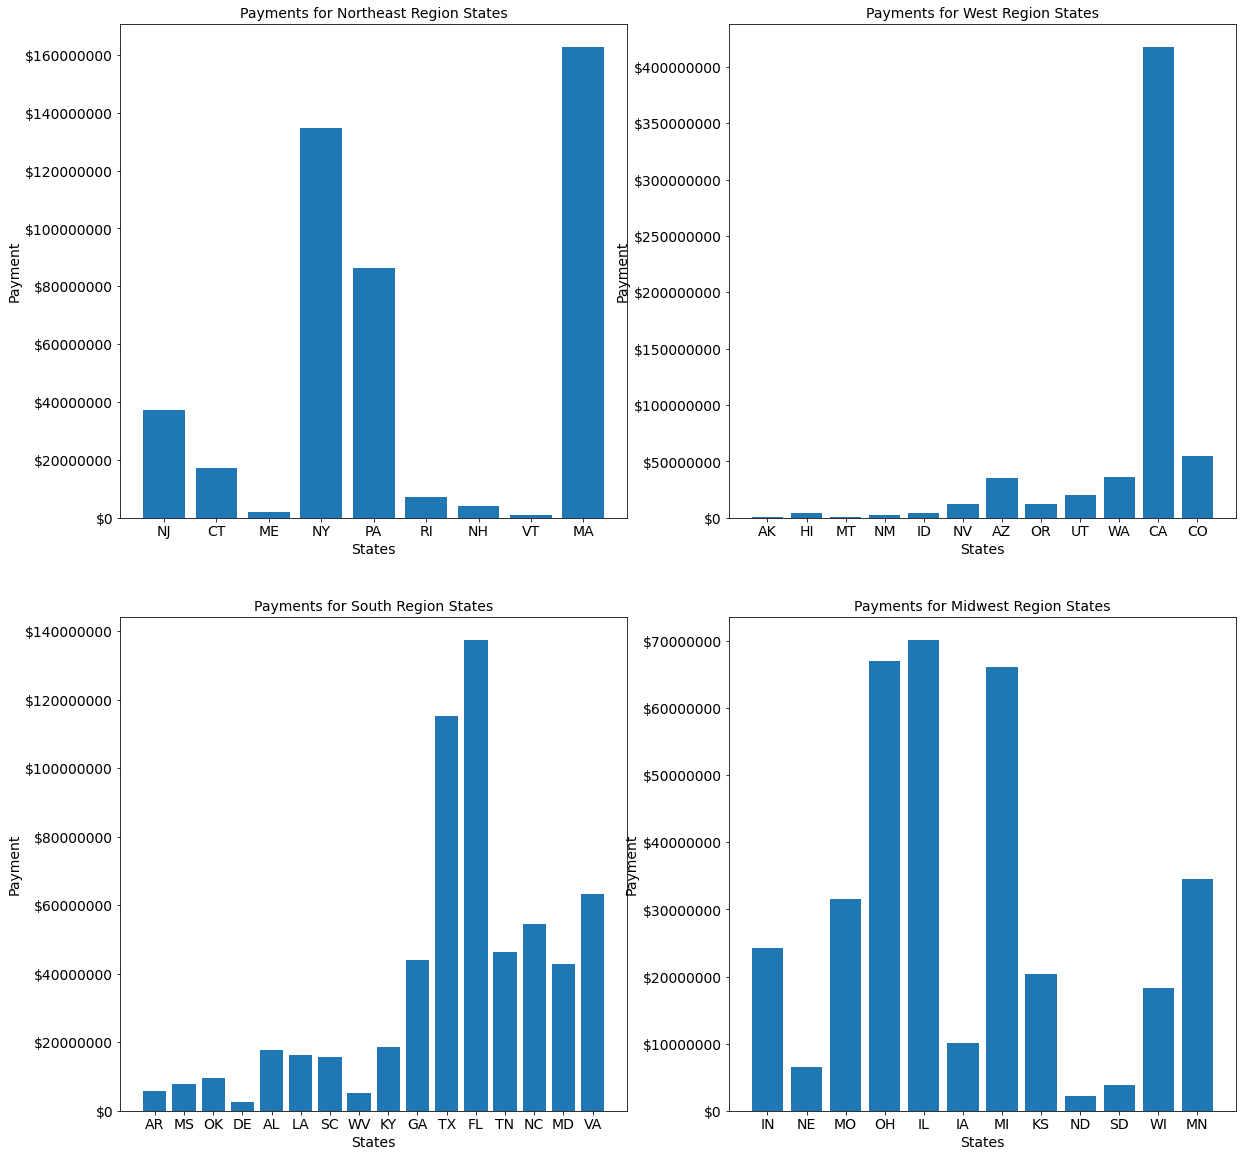

In [11]:
fig, axs = plt.subplots(2, 2,figsize=(20,20))
y_scale = state_desc_stats['sum']
fontsize = 14

axs[0, 0].bar(northeast_region['Recipient_State'], northeast_region['sum'])
axs[0, 0].set_title('Payments for Northeast Region States', fontsize=fontsize)
axs[0, 0].set_xlabel('States', fontsize=fontsize)
axs[0, 0].set_ylabel('Payment', fontsize=fontsize)
axs[0, 0].set_xticklabels(northeast_region['Recipient_State'], fontsize=fontsize)
axs[0, 0].set_yticklabels(y_scale, fontsize=fontsize)
axs[0, 0].yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))


axs[0, 1].bar(west_region['Recipient_State'], west_region['sum'])
axs[0, 1].set_xlabel('States', fontsize=fontsize)
axs[0, 1].set_ylabel('Payment', fontsize=fontsize)
axs[0, 1].set_title('Payments for West Region States', fontsize=fontsize)
axs[0, 1].set_xticklabels(west_region['Recipient_State'], fontsize=fontsize)
axs[0, 1].set_yticklabels(y_scale, fontsize=fontsize)
axs[0, 1].yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))

axs[1, 0].bar(south_region['Recipient_State'], south_region['sum'])
axs[1, 0].set_xlabel('States', fontsize=fontsize)
axs[1, 0].set_ylabel('Payment', fontsize=fontsize)
axs[1, 0].set_title('Payments for South Region States', fontsize=fontsize)
axs[1, 0].set_xticklabels(south_region['Recipient_State'], fontsize=fontsize)
axs[1, 0].set_yticklabels(y_scale, fontsize=fontsize)
axs[1, 0].yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))

axs[1, 1].bar(midwest_region['Recipient_State'], midwest_region['sum'])
axs[1, 1].set_xlabel('States', fontsize=fontsize)
axs[1, 1].set_ylabel('Payment', fontsize=fontsize)
axs[1, 1].set_title('Payments for Midwest Region States', fontsize=fontsize)
axs[1, 1].set_xticklabels(midwest_region['Recipient_State'], fontsize=fontsize)
axs[1, 1].set_yticklabels(y_scale, fontsize=fontsize)
axs[1, 1].yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))

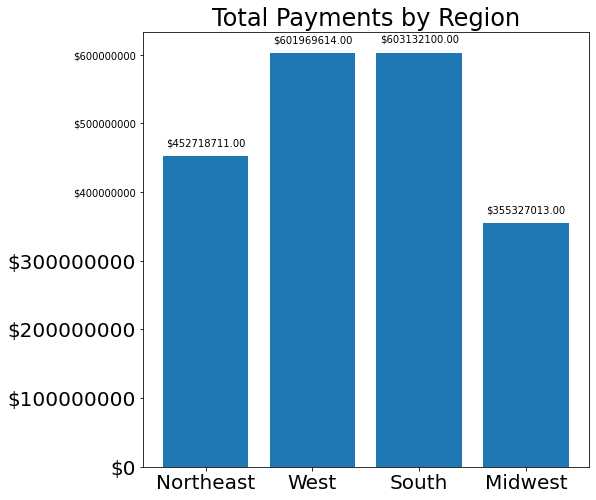

In [12]:
region_sum = []
ne = sum(northeast_region['sum'])
w= sum(west_region['sum'])
s= sum(south_region['sum'])
mw = sum(midwest_region['sum'])

region_sum.append(ne)
region_sum.append(w)
region_sum.append(s)
region_sum.append(mw)

region_sum
region_lst = ['Northeast', 'West', 'South', 'Midwest']

fig, ax = plt.subplots(figsize=(8,8))

ax.bar(region_lst, region_sum)
ax.set_title('Total Payments by Region', fontsize=24)
ax.set_xticklabels(region_lst, fontsize=20)
ax.set_yticklabels(region_sum, fontsize=20)
ax.yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))

for x,y in zip(region_lst,region_sum):
    label = "${:.2f}".format(int(y))
    plt.annotate(label, 
                 (x,y),
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center') 

plt.show()

In [13]:
del region_sum, region_lst, state_desc_stats, df, top_10_states, bottom_10_states, midwest_region, northeast_region, west_region, south_region, Midwest_Region, Northeast_Region, West_Region, South_Region

# Exploring the Data using Bar Graphs
One of our goals was to visualize the competitivness between pharmaceuticals. Originally, we hoped to compare the amount spent by each unique pharma. However, there are over 1500 unique pharmaceuticals mkaing it difficult to visualize.  Therefore, we created a bar graph to show how the sum of payments made by the top 10 and bottom 10 pharmaceuticals.

## Data Prep

In [14]:
cols = ['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name','Total_Amount_of_Payment_USDollars']
data = df_from_csv_stream(cols)

Processing file: OP_DTL_GNRL_PGYR2020_P06302021.csv
Processed 1000000 rows.
Processed 2000000 rows.
Processed 3000000 rows.
Processed 4000000 rows.
Processed 5000000 rows.
Processed 6000000 rows.


In [15]:
data.dropna(subset=cols)
desc_data=data.groupby(['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name']).Total_Amount_of_Payment_USDollars.agg([sum]).reset_index()
df=pd.DataFrame(data=desc_data)
print(len(df))

1562


## Plotting All Pharmaceutical Payers
There are 1562 unique pharmaceuticals. Therefore, the bar graph was orginially packed. Instead, we chose to plot the 10 pharmaceuticals spending the most on hospitals and/or phyisicans. This way we could compare maximum and minimums spent closely. 

(array([1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05, 1.e+07, 1.e+09,
        1.e+11]), <a list of 9 Text major ticklabel objects>)

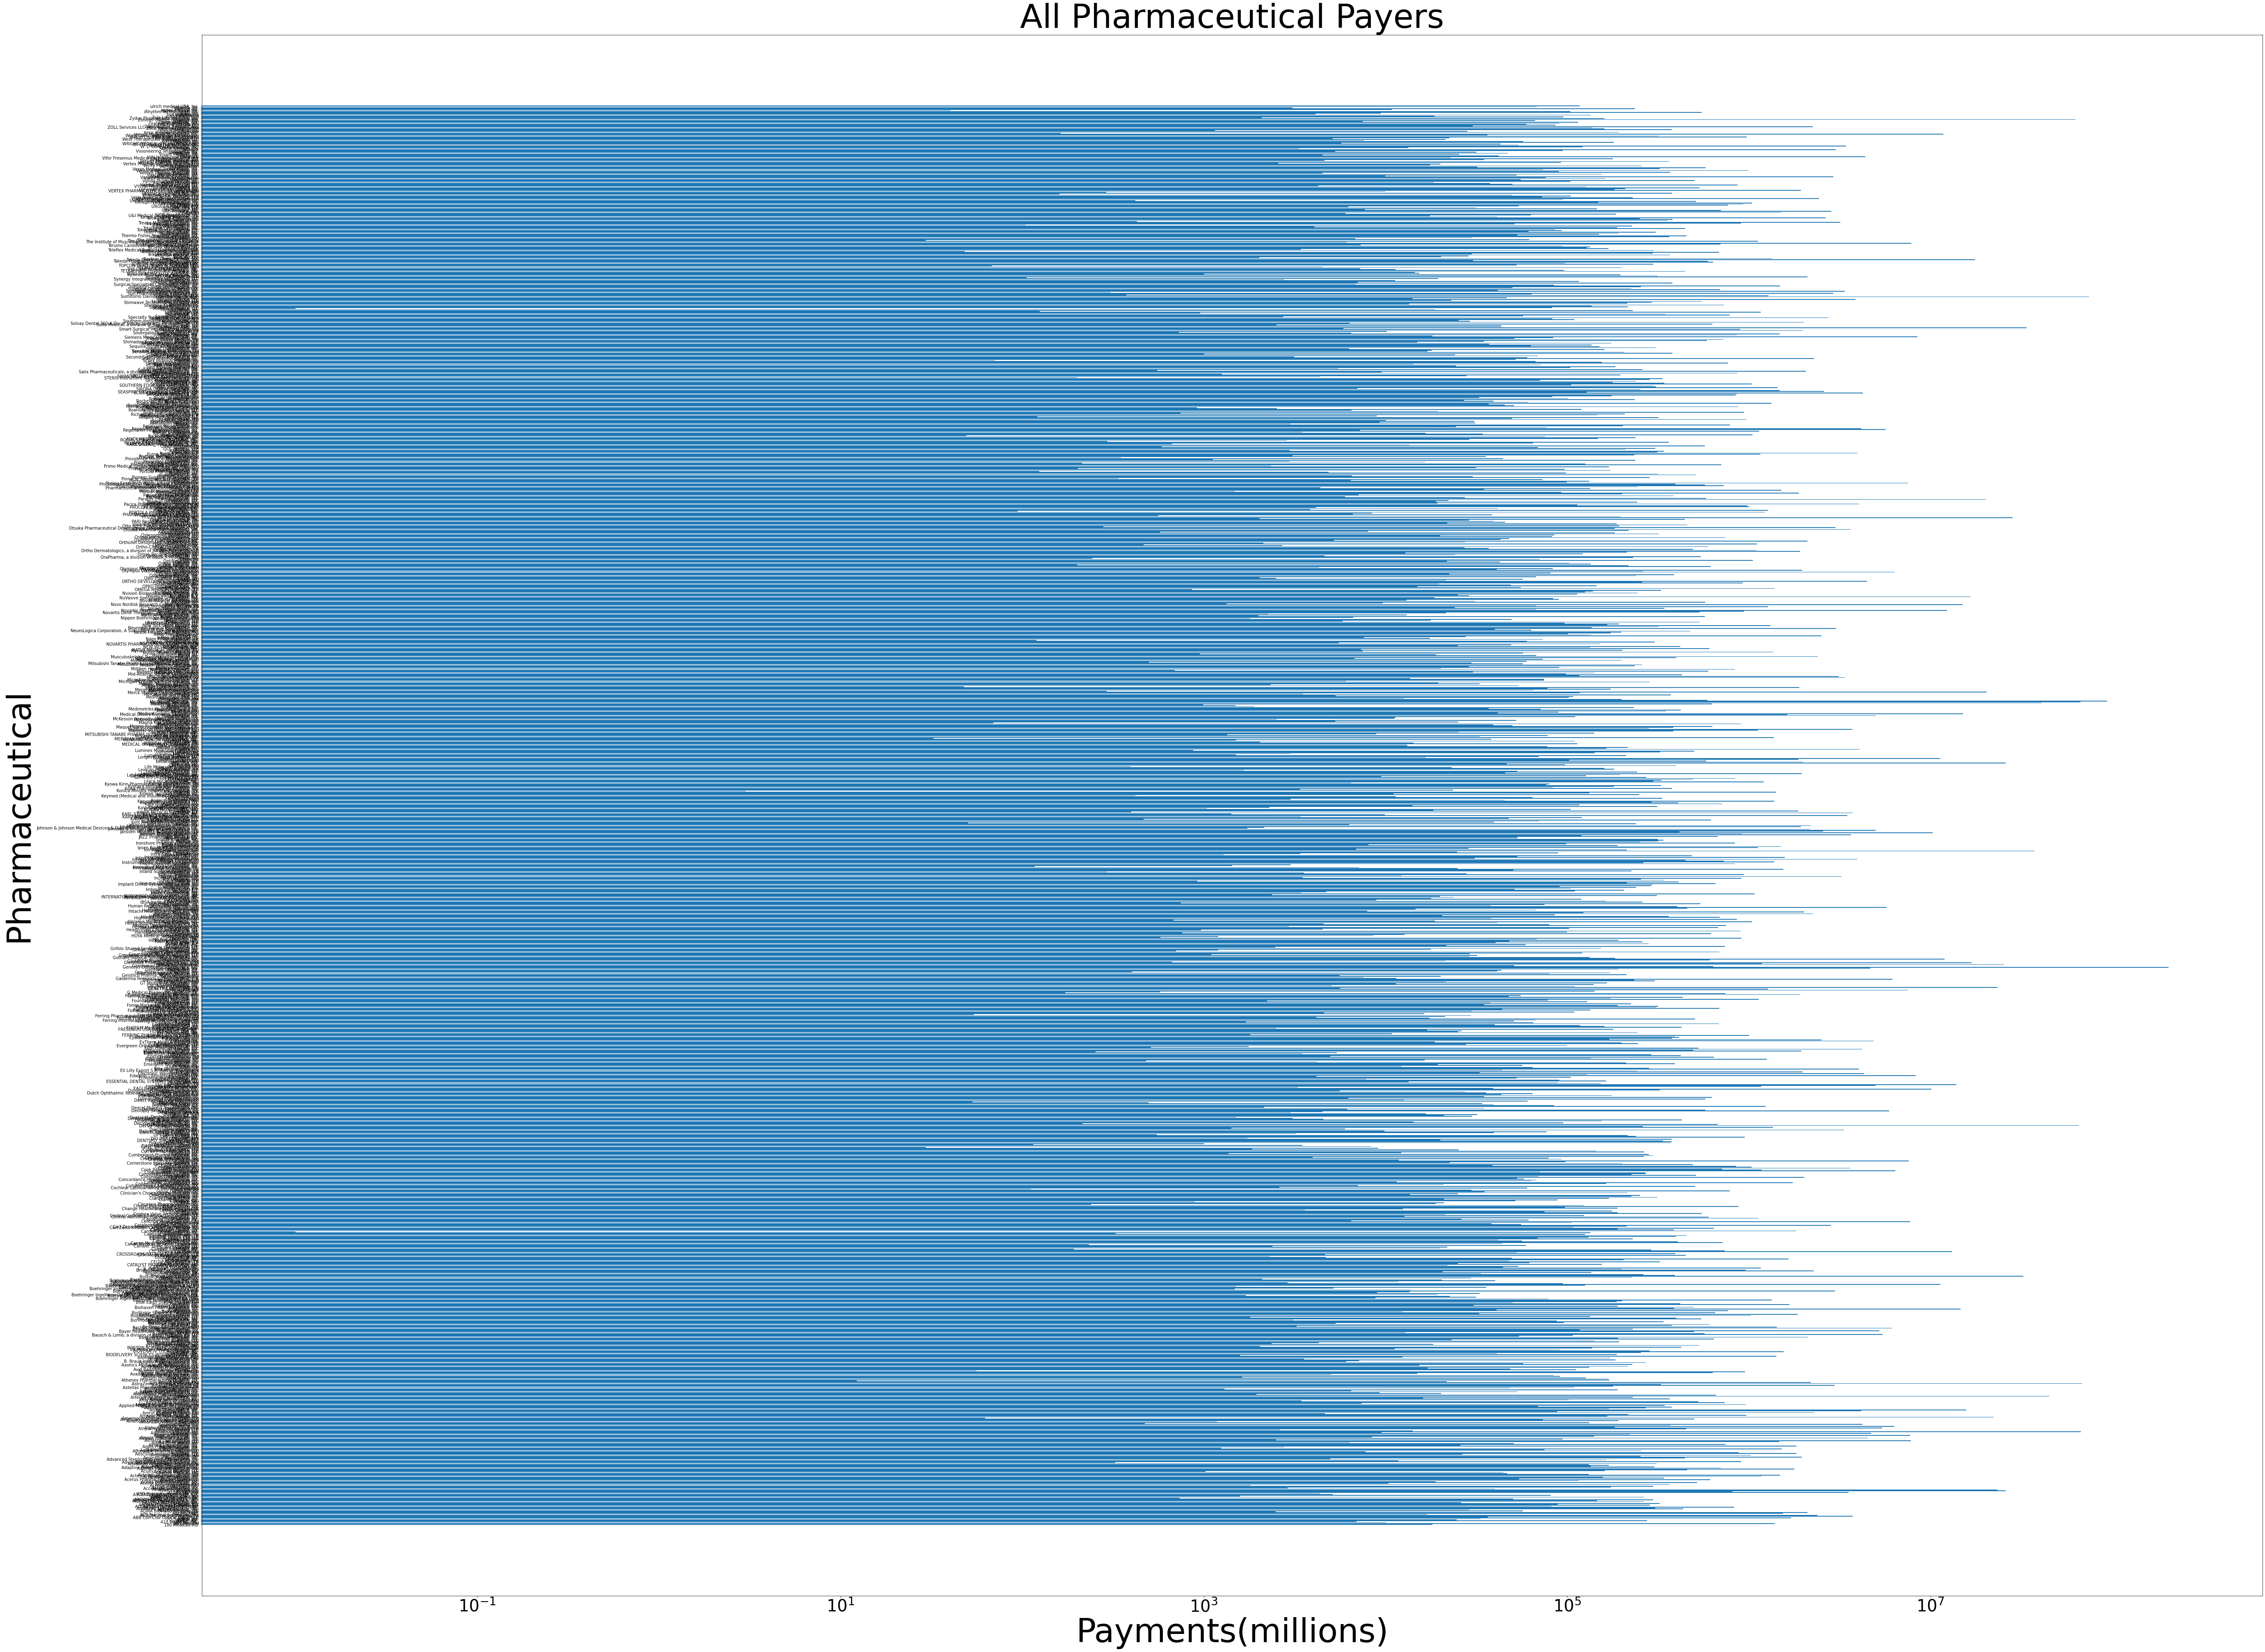

In [16]:
pharma=df["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"]
money=df["sum"]
fig,ax=plt.subplots(figsize=(90,70))
ax.barh(pharma,money)
plt.xscale("log")
ax.set_title("All Pharmaceutical Payers",size=80)
ax.set_xlabel("Payments(millions)",size=80)
ax.set_ylabel("Pharmaceutical",size=80)
plt.xticks(fontsize=40)

## Plotting the Top 10 and Bottom 10

In [17]:
top_10_pharma=df.nlargest(10,['sum']).sort_values('sum')
top_10_pharma['sum'] = top_10_pharma['sum'].apply(lambda x: x / (10**6))
low_10_pharma=df.nsmallest(10,['sum'])
low_10_pharma

Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name    sum
322                               Cardiosolutions, Inc.              0.01
1338                                 Spirus Medical LLC              0.01
807                                         Kobold, LLC              3.00
158                                      Asuragen, Inc.             12.30
1413                    The Orthopaedic Implant Company             29.43
415                                   Cytyc Corporation             29.44
865                 MERIDIAN MEDICAL TECHNOLOGIES, INC.             32.50
1556                                iScreen Vision Inc.             40.53
922                            Merz North America, Inc.             47.69
1401                       Teleflex Medical Canada Inc.             48.32

Text(0, 0.5, 'Pharmaceutical')

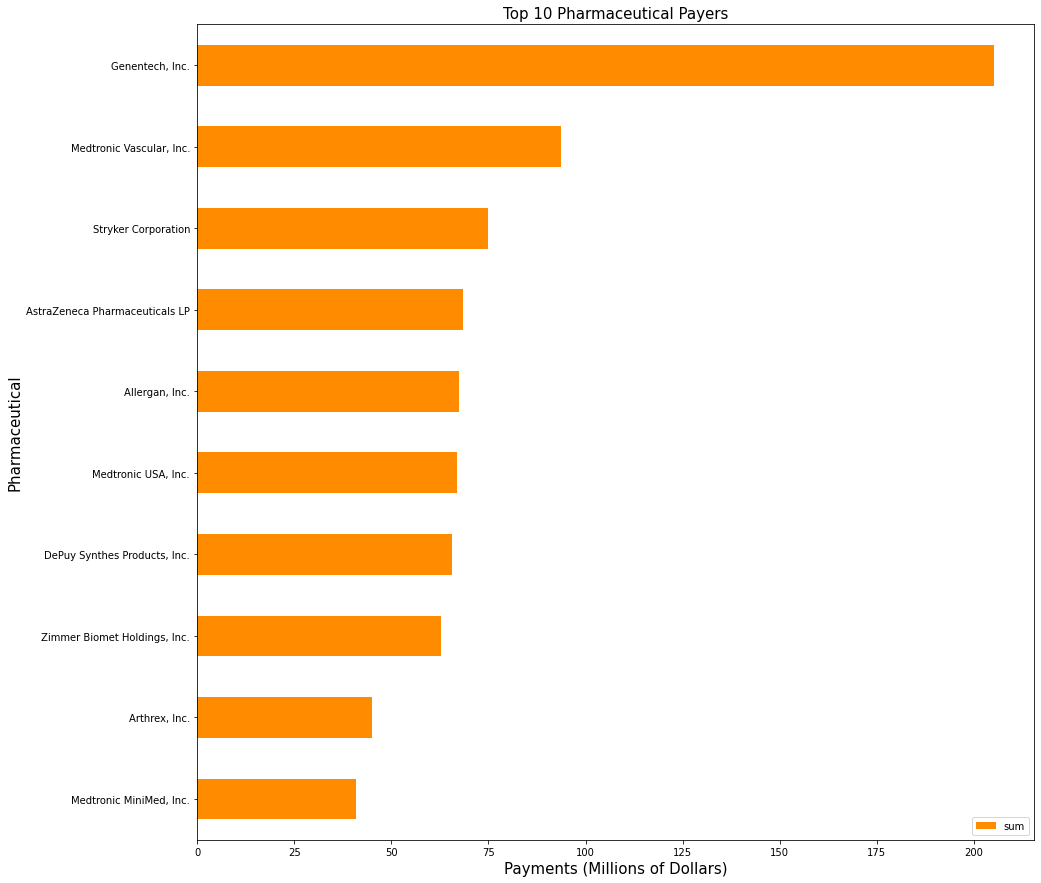

In [18]:
df=pd.DataFrame(top_10_pharma,columns=["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name","sum"])
ax=df.plot(x="Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name", y="sum", kind="barh", figsize=(15, 15), color="darkorange")
ax.set_title("Top 10 Pharmaceutical Payers",size=15)
ax.set_xlabel("Payments (Millions of Dollars)",size=15)
ax.set_ylabel("Pharmaceutical",size=15)

Text(0, 0.5, 'Pharmaceutical')

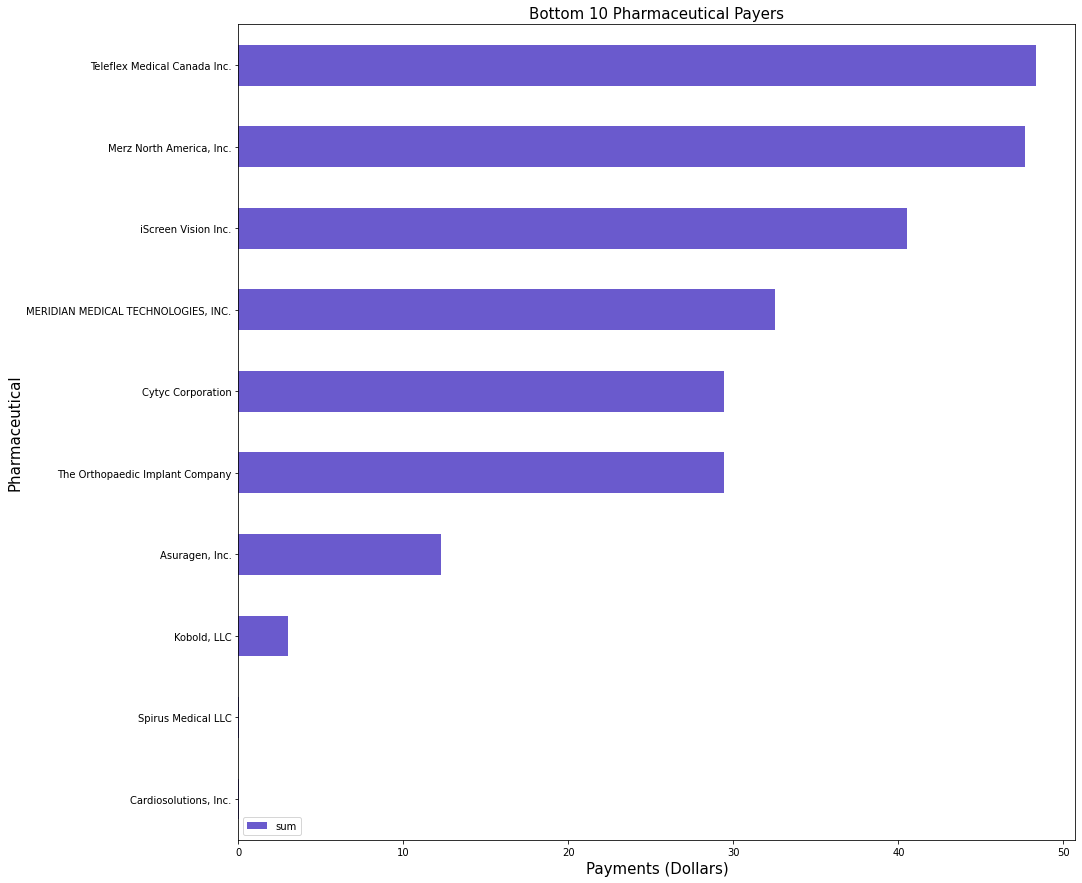

In [19]:
df=pd.DataFrame(low_10_pharma,columns=["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name","sum"])
ax=df.plot(x="Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name", y="sum", kind="barh", figsize=(15, 15),color="slateblue")
ax.set_title("Bottom 10 Pharmaceutical Payers",size=15)
ax.set_xlabel("Payments (Dollars)",size=15)
ax.set_ylabel("Pharmaceutical",size=15)

In [20]:
del data, df, top_10_pharma, low_10_pharma, desc_data, money, pharma

# Analyzing payments by specialties using Pandas and Matplotlib.
The team wanted to also analyze the sums being paid to specialties by pharmaceuticals. We targeted the data broadly and specifically. CMS collected data from subspecialties and assigned them to a broad specialty. For example, subspecialties internal medicine and orthopedic surgery, although different, would fall under the broad category of 'osteopathic and allopathic surgery'. The following will analyze the specialties from the broad broad perspective rather than the subspecialty. 

## Data Prep

In [21]:
cols = ['Physician_Specialty','Total_Amount_of_Payment_USDollars']
data = df_from_csv_stream(cols)
data.dropna(subset=['Physician_Specialty','Total_Amount_of_Payment_USDollars'])

Processing file: OP_DTL_GNRL_PGYR2020_P06302021.csv
Processed 1000000 rows.
Processed 2000000 rows.
Processed 3000000 rows.
Processed 4000000 rows.
Processed 5000000 rows.
Processed 6000000 rows.


Physician_Specialty  Total_Amount_of_Payment_USDollars
1        Allopathic & Osteopathic Physicians|Ophthalmology                             105.03
2        Allopathic & Osteopathic Physicians|Ophthalmology                              11.69
3        Allopathic & Osteopathic Physicians|Ophthalmology                              32.76
4        Allopathic & Osteopathic Physicians|Ophthalmology                             537.70
5        Allopathic & Osteopathic Physicians|Ophthalmology                             550.00
...                                                    ...                                ...
5783979  Allopathic & Osteopathic Physicians|Family Med...                              24.38
5783980  Allopathic & Osteopathic Physicians|General Pr...                             129.46
5783981  Allopathic & Osteopathic Physicians|Anesthesio...                              83.36
5783982  Allopathic & Osteopathic Physicians|General Pr...                             129.46
5783983  Allopathic & Osteopathic Physicians|Anesthesio...                              20.57

[5751949 rows x 2 columns]

In [22]:
specialty_data=data.groupby(['Physician_Specialty']).Total_Amount_of_Payment_USDollars.agg([sum]).reset_index()
df=pd.DataFrame(data=specialty_data)

## Creating a Chart for All Specialties

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

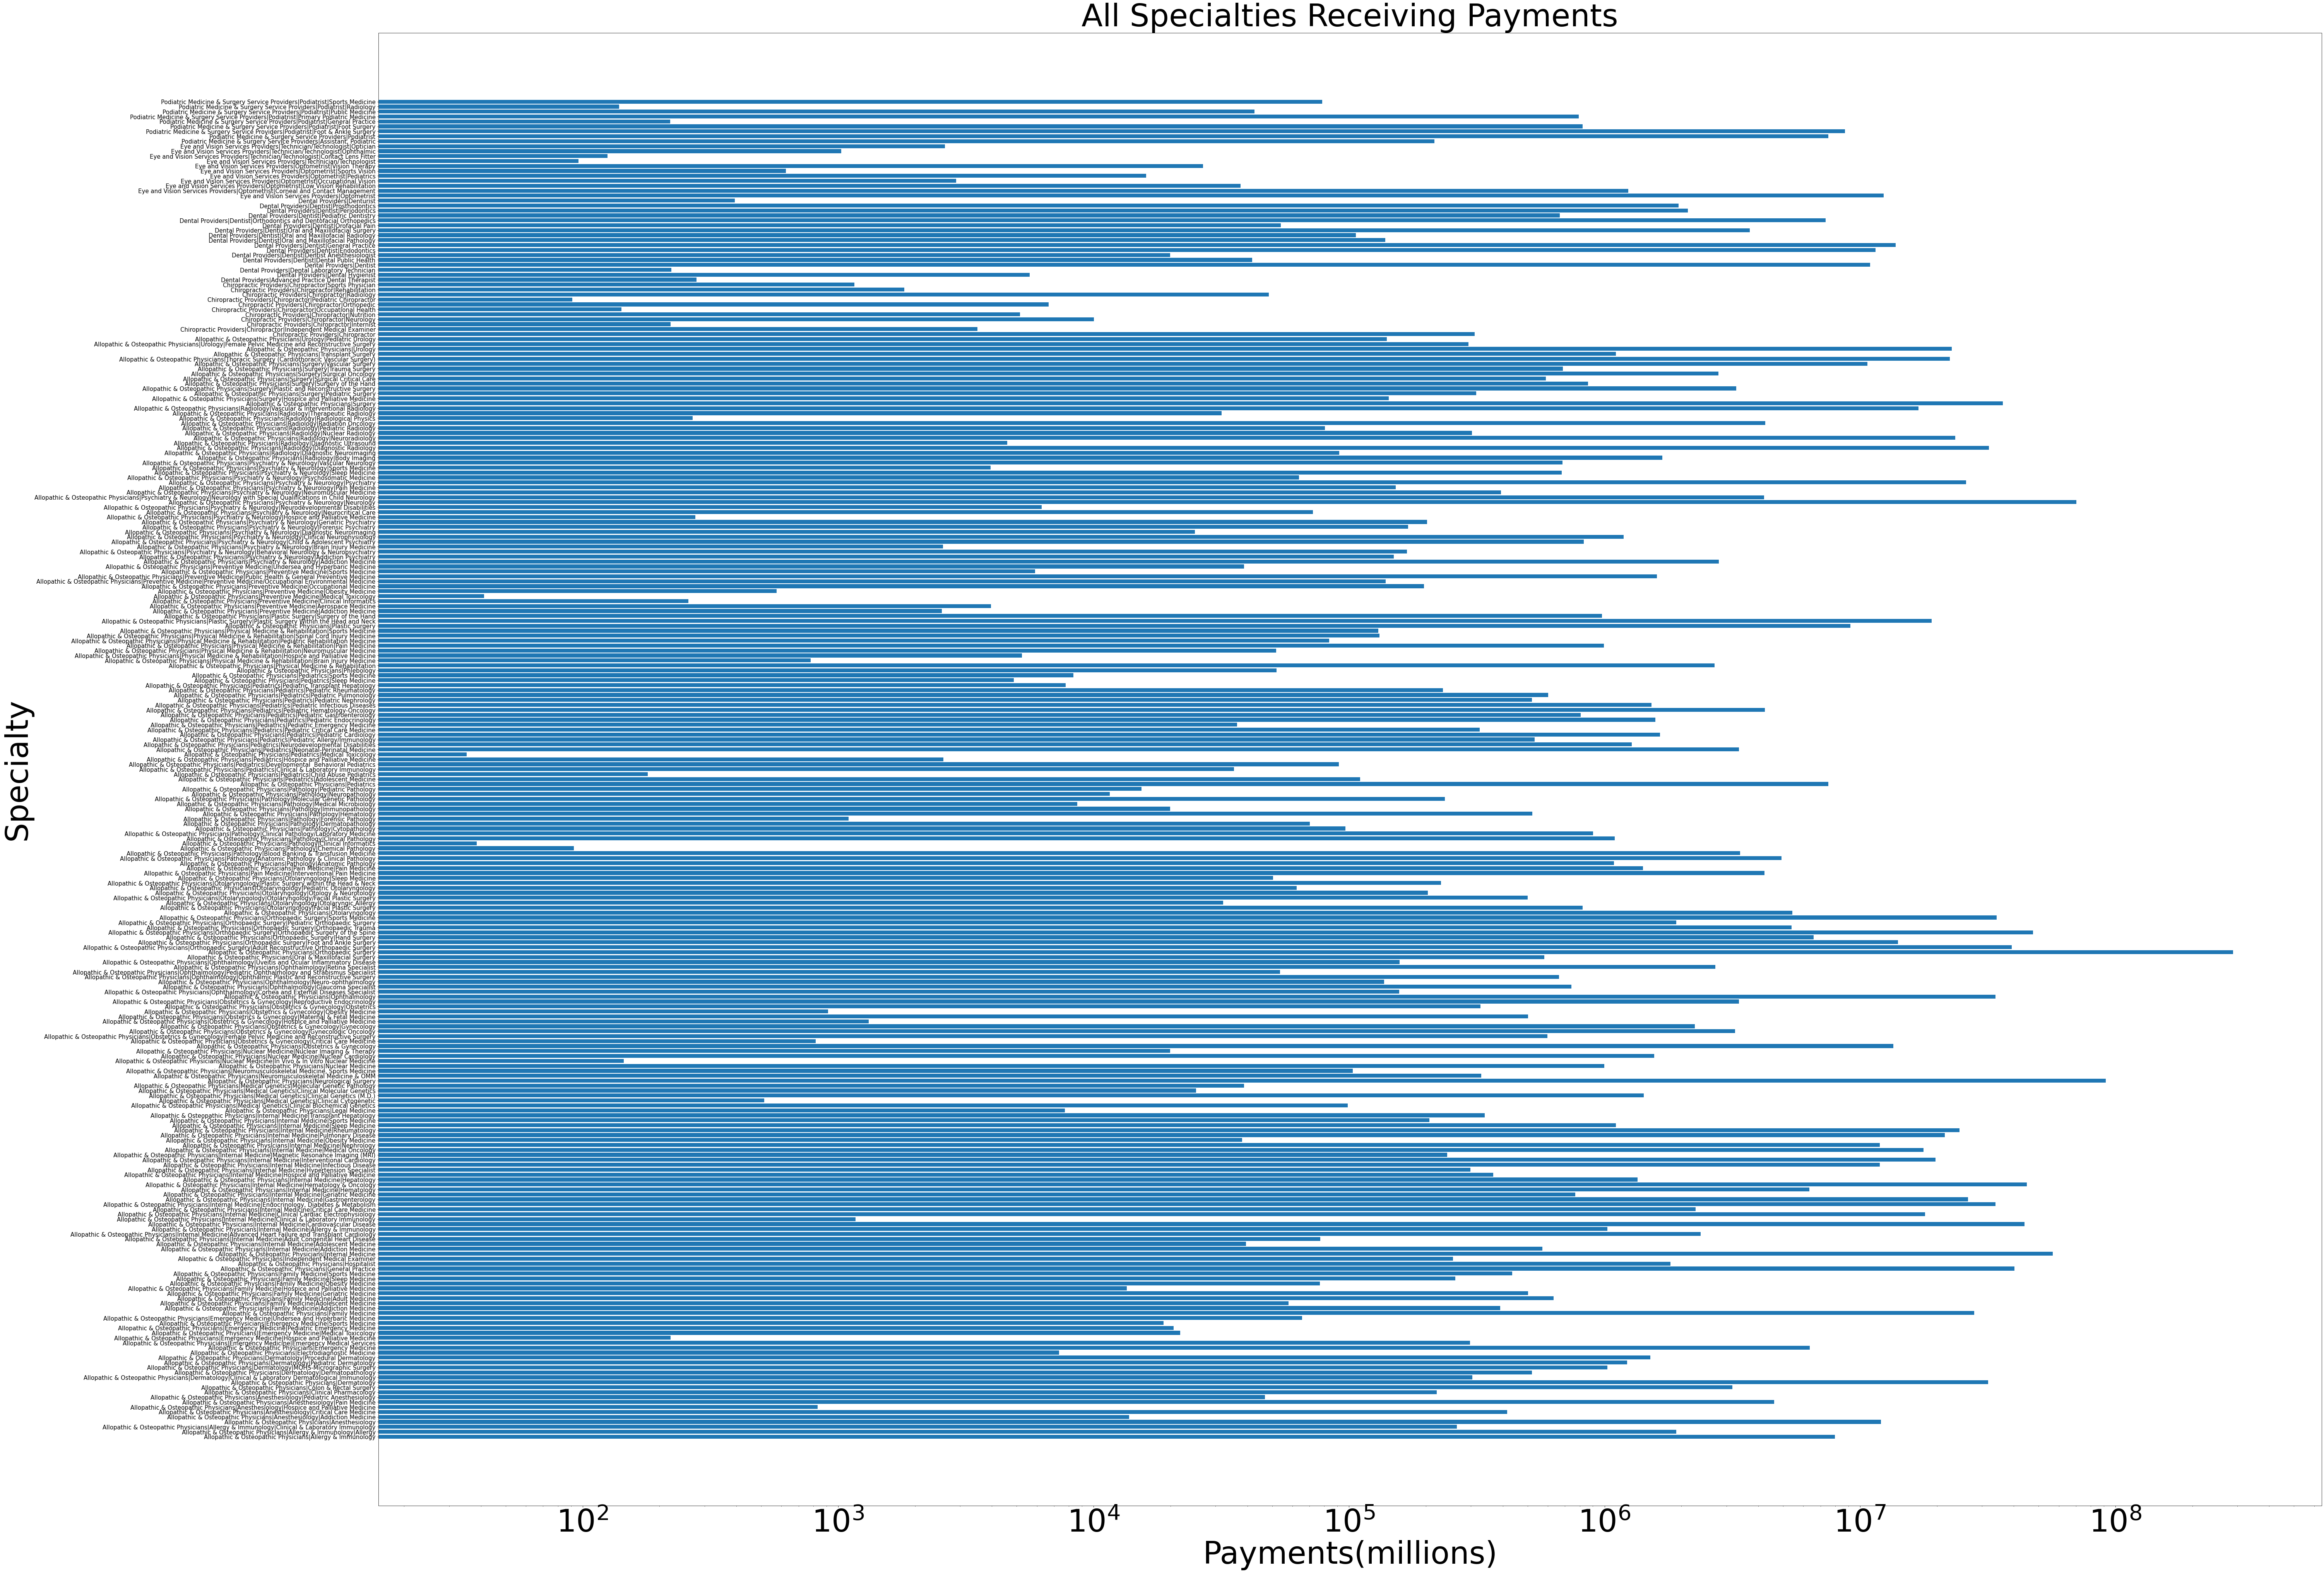

In [23]:
specialty=df["Physician_Specialty"]
amount=df["sum"]
fig,ax=plt.subplots(figsize=(90,70))
ax.barh(df["Physician_Specialty"], df["sum"])
plt.xscale("log")
ax.set_title("All Specialties Receiving Payments",size=80)
ax.set_xlabel("Payments(millions)",size=80)
ax.set_ylabel("Specialty",size=80)
plt.xticks(fontsize=80)
plt.yticks(fontsize=15)
# Couldn't figure out how to get this ugly output before the chart to go away :(

## Plotting the Top 10 and Bottom 10 Physician Specialties


In [24]:
top_10_spec=df.nlargest(10,['sum']).sort_values('sum')
top_10_spec['sum'] = top_10_spec['sum'].apply(lambda x: x / 10**6)
bottom_10_spec=df.nsmallest(10,['sum'])

Text(0, 0.5, 'Millions')

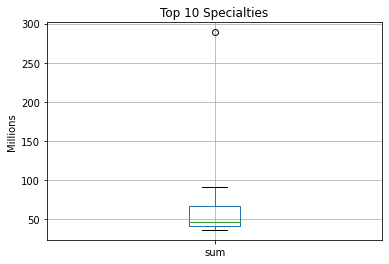

In [25]:
ax=top_10_spec.boxplot(column="sum")
ax.set_title('Top 10 Specialties')
ax.set_ylabel('Millions')

Text(0, 0.5, 'Dollars')

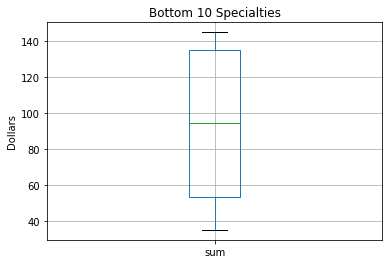

In [26]:
ax=bottom_10_spec.boxplot(column="sum")
ax.set_title('Bottom 10 Specialties')
ax.set_ylabel('Dollars')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

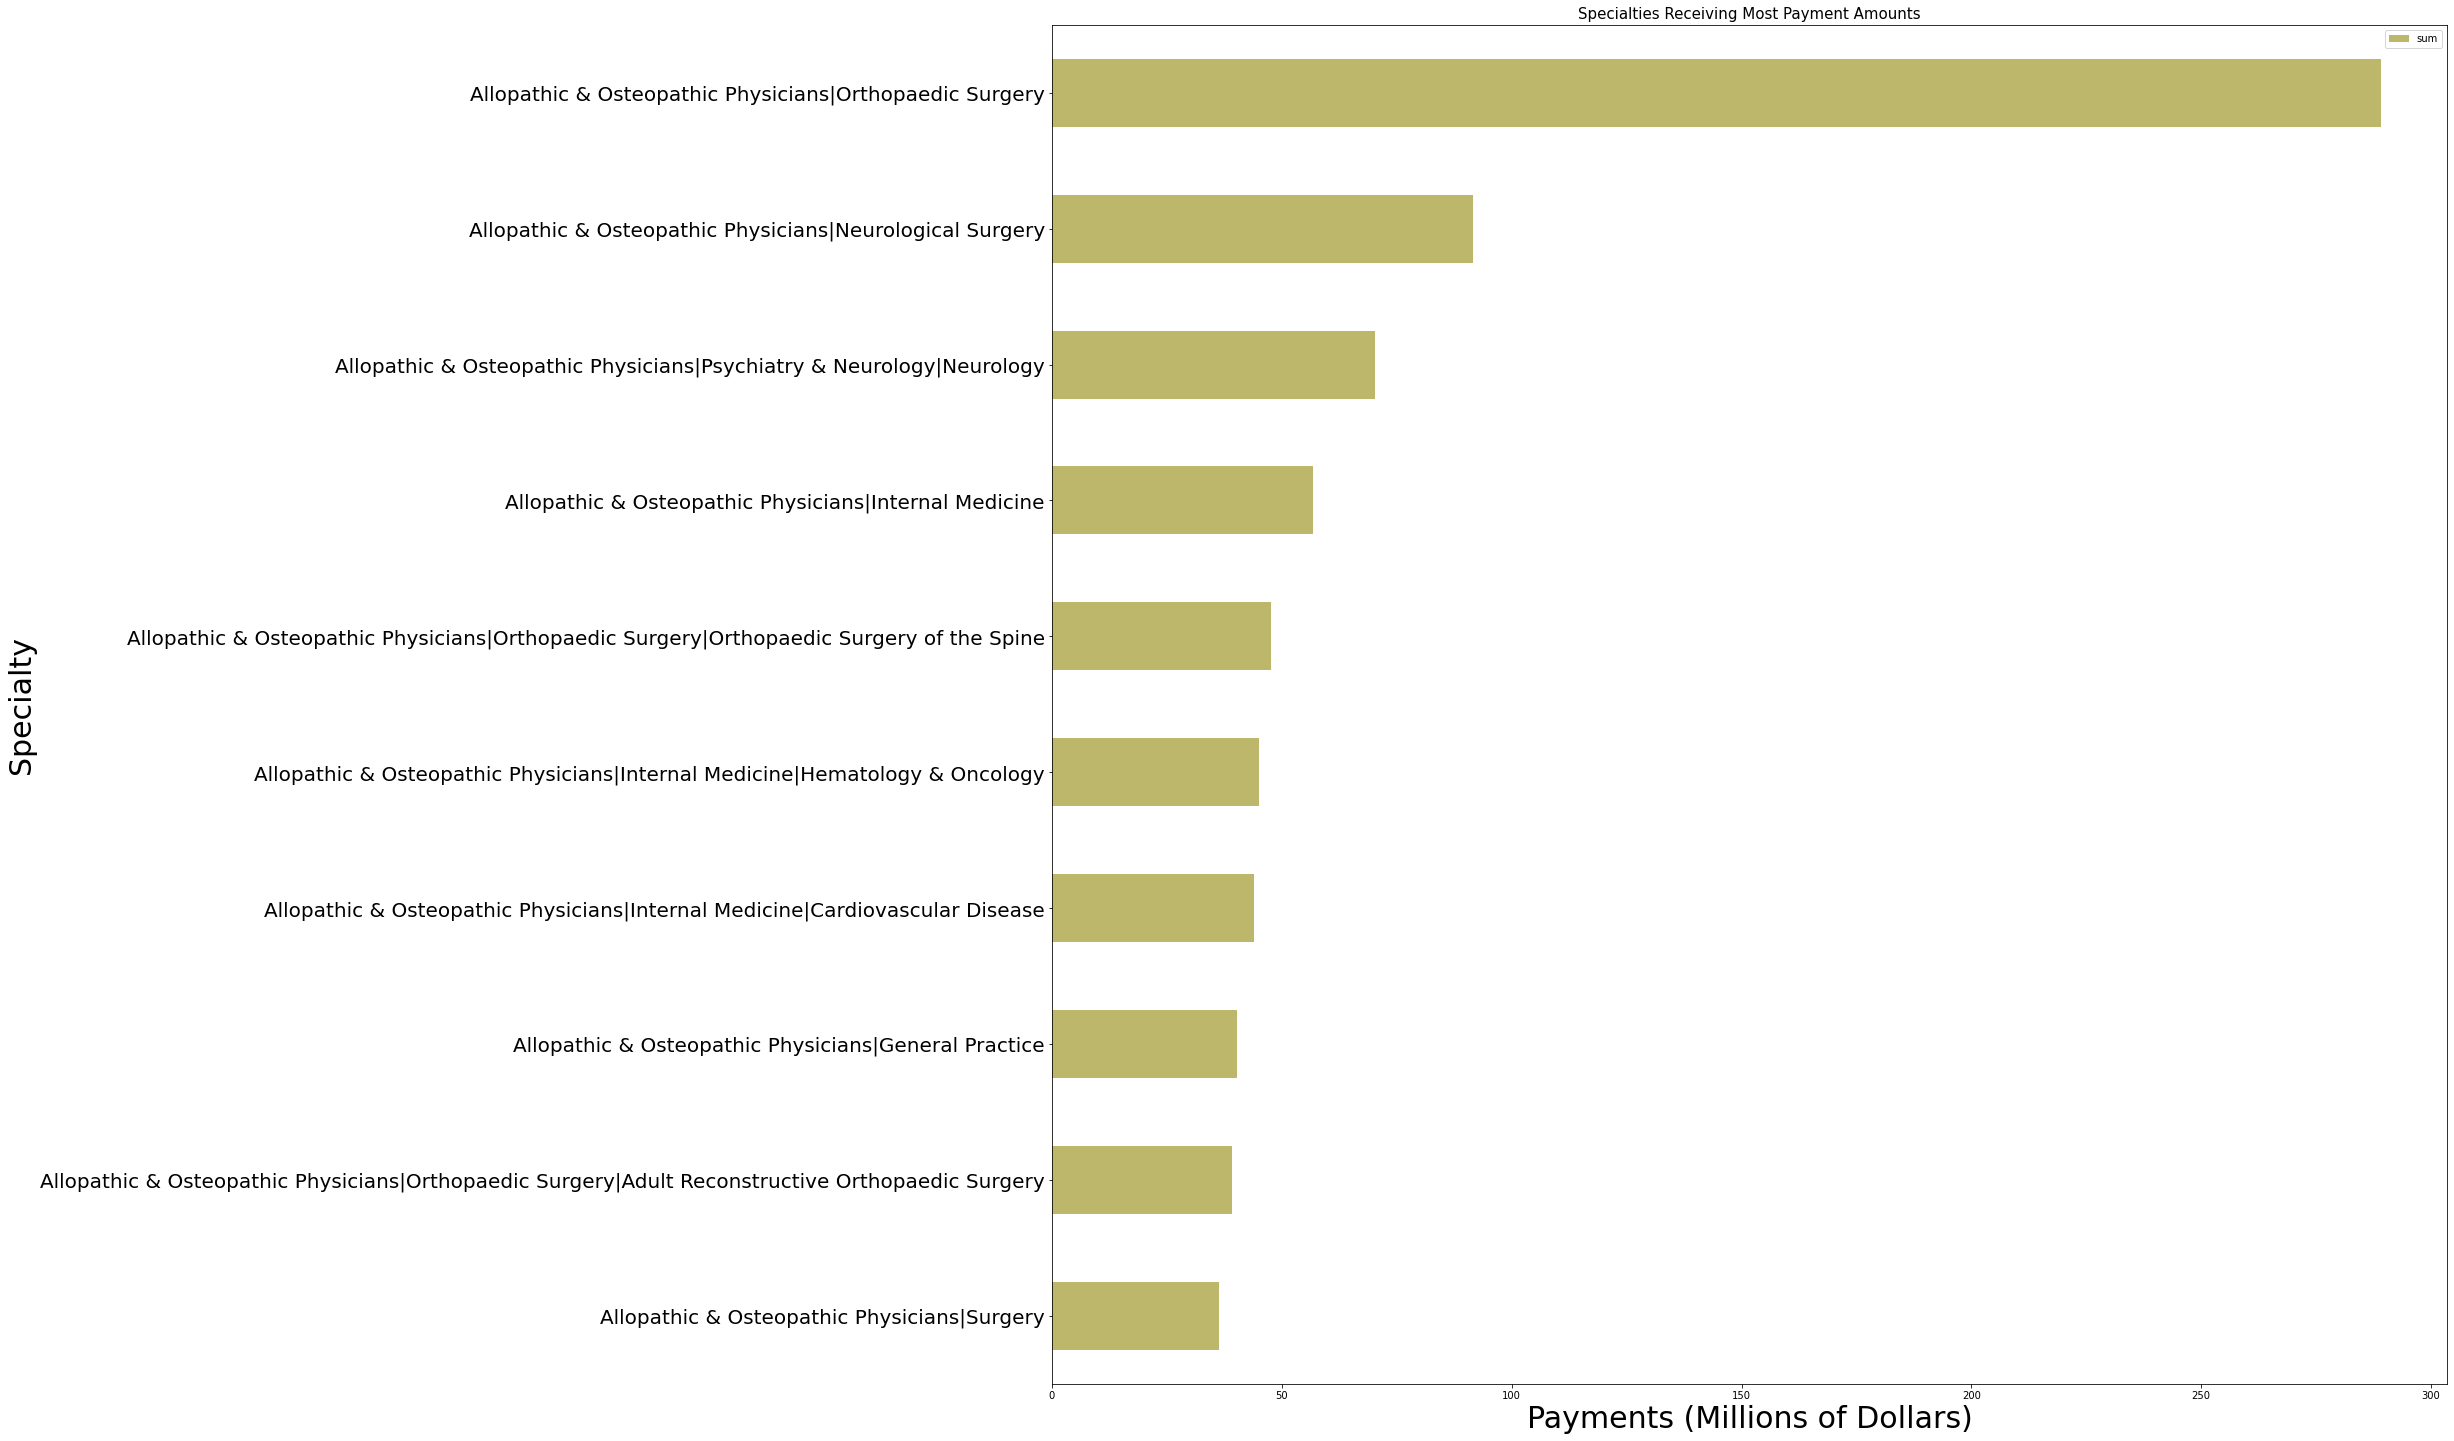

In [27]:
df=pd.DataFrame(top_10_spec,columns=["Physician_Specialty","sum"])
ax=df.plot(x="Physician_Specialty", y="sum", kind="barh", figsize=(25, 25),color="darkkhaki")
ax.set_title("Specialties Receiving Most Payment Amounts",size=15)
ax.set_xlabel("Payments (Millions of Dollars)",size=30)
ax.set_ylabel("Specialty",size=30)
plt.yticks(fontsize=20)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

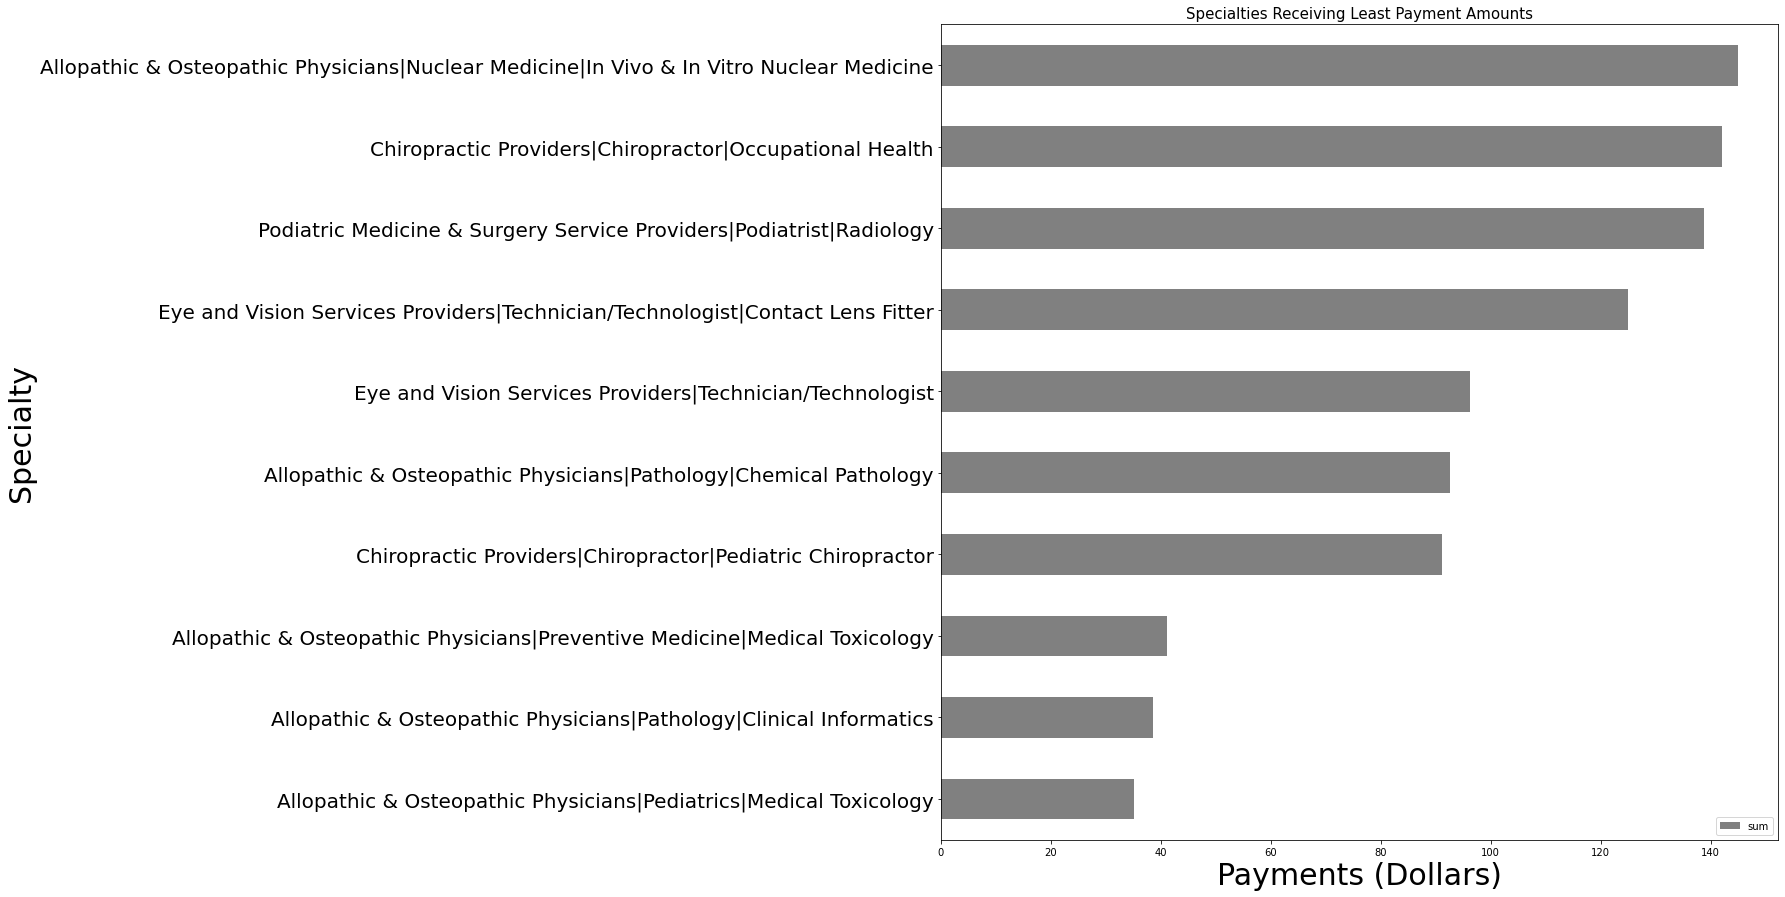

In [28]:
df=pd.DataFrame(bottom_10_spec,columns=["Physician_Specialty","sum"])
ax=df.plot(x="Physician_Specialty", y="sum", kind="barh", figsize=(15, 15),color="grey")
ax.set_title("Specialties Receiving Least Payment Amounts",size=15)
ax.set_xlabel("Payments (Dollars)",size=30)
ax.set_ylabel("Specialty",size=30)
plt.yticks(fontsize=20)

In [29]:
del data, df, top_10_spec, bottom_10_spec, amount, specialty, specialty_data, y_scale

# A deeper dive into Physician Specialties
As you might have noticed from above, the specialties are actually in a 3 tier heirarchy and are separated by the '|' symbol. The key Motivation in the following steps is to be able to analyse the total spend in USD at a Physician's Specialty level. This would give us visibility into the various speciality area level spending and provide guidance on the ones where the Pharma and instrumentation companies are spending the most.

## Data Prep

In [30]:
cols = ['Physician_Specialty', 'Total_Amount_of_Payment_USDollars', 'Recipient_State', 'Date_of_Payment']
states = ['IN', 'FL', 'TX', 'CA']
df = df_from_csv_stream(cols, states=states)
df[['Specialty_1', 'Specialty_2', 'Specialty_3']] = df['Physician_Specialty'].str.split('|', expand=True)
df[['Month', 'Day', 'Year']] = df["Date_of_Payment"].str.split('/', expand=True)

Processing file: OP_DTL_GNRL_PGYR2020_P06302021.csv
Processed 1000000 rows.
Processed 2000000 rows.
Processed 3000000 rows.
Processed 4000000 rows.
Processed 5000000 rows.
Processed 6000000 rows.


In [31]:
print(f"Percent missing values: {df['Specialty_3'].isnull().sum()/len(df['Specialty_3'])*100:.2f}%")

Percent missing values: 51.13%


In [32]:
print(f"Percent missing values: {df['Specialty_2'].isnull().sum()/len(df['Specialty_2'])*100:.2f}%")

Percent missing values: 0.40%


## Total Spending at the Highest Specialty Tier
A pie chart was tried out as the visualization option to plot Specialty 1(Super Specialty) level spend. Upong plotting it did give a high level view of the spend pattern, however details needed the granularity to be shifted to Specialty level 2(Sub Specialty level).

Text(0.5, 1.0, 'Total Spending at a Speciality Level')

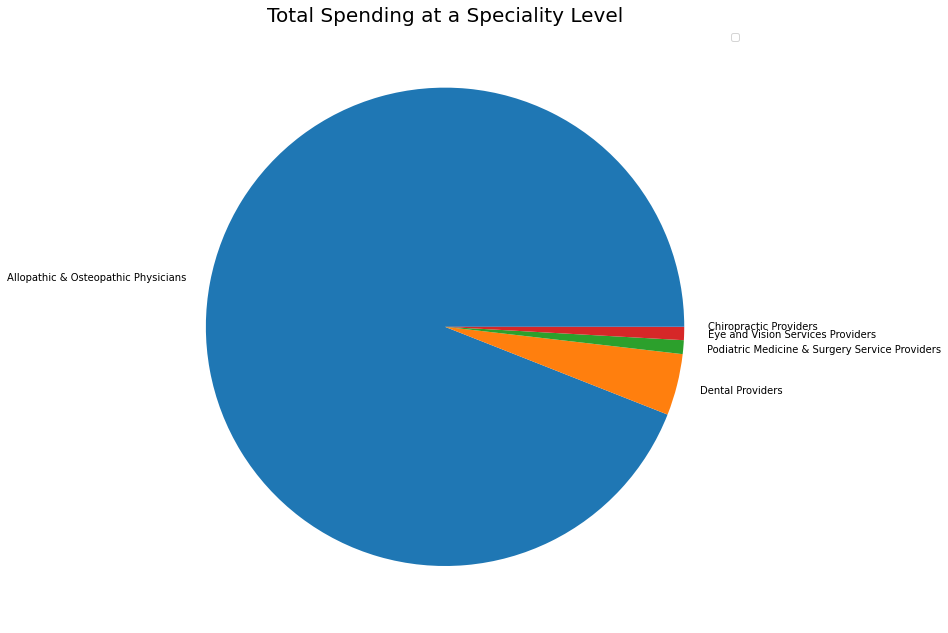

In [33]:
amount_speciality_1 = df.groupby(['Specialty_1']).agg({'Total_Amount_of_Payment_USDollars':sum}).sort_values(['Total_Amount_of_Payment_USDollars'],ascending = False)
plot = amount_speciality_1.plot.pie(y='Total_Amount_of_Payment_USDollars', figsize=(11,11),ylabel = '',xlabel = '')
plt.legend('')
plt.axis('off')
plt.title('Total Spending at a Speciality Level',fontsize=20)

In [34]:
amount_specialty_2 = df.groupby(['Specialty_2']).agg({'Total_Amount_of_Payment_USDollars':sum}).sort_values(['Total_Amount_of_Payment_USDollars'],ascending = False).head(10).reset_index()
amount_specialty_2.columns = ['Sub-Specialty', 'Total_Amount_of_Payment_USDollars']
amount_specialty_2


Sub-Specialty  Total_Amount_of_Payment_USDollars
0     Orthopaedic Surgery                       1.218868e+08
1       Internal Medicine                       1.003030e+08
2    Neurological Surgery                       3.488129e+07
3               Radiology                       3.155656e+07
4  Psychiatry & Neurology                       2.825816e+07
5        General Practice                       2.354271e+07
6         Plastic Surgery                       2.124289e+07
7                 Dentist                       2.033747e+07
8                 Surgery                       1.562903e+07
9             Dermatology                       1.089235e+07

## Box Plot of the Top 3 Tier 1 Specialties
Box whisker plot was tried out, given the wide range of variaton between the spend in the top 5 sub specialities, a log scale approach was tried out. This was not effective and was too complex for a reader to understand. This was dropped.

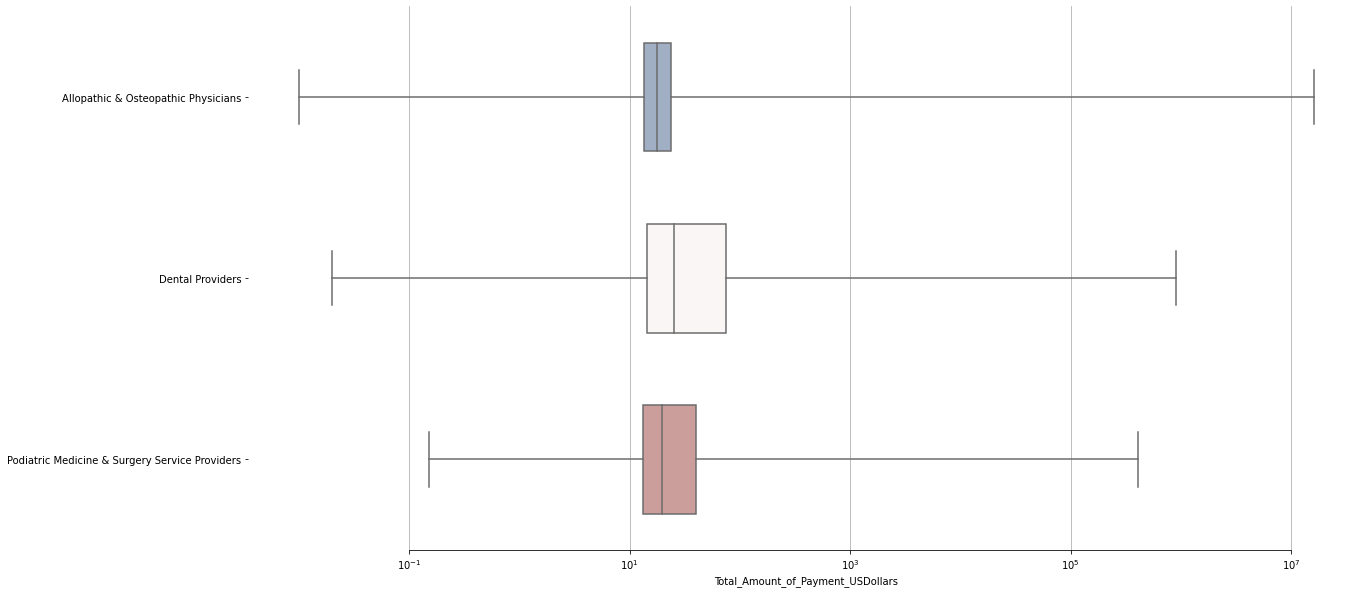

In [35]:
# Top 3 specialty areas of spend
Top3 = ['Allopathic & Osteopathic Physicians','Podiatric Medicine & Surgery Service Providers','Dental Providers']
amount_specialty_1 = df.loc[df['Specialty_1'].isin(Top3)]


# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(20, 10))
ax.set_xscale("log")

sns.boxplot(x="Total_Amount_of_Payment_USDollars", y="Specialty_1", data=amount_specialty_1,
             whis=[0, 100],width=0.6, palette="vlag")

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

## Total Spending for the Top 5 Second Tier Specialties


Text(0.5, 1.0, 'Total spend at a Sub-specialty 1evel for top 5 Spend areas')

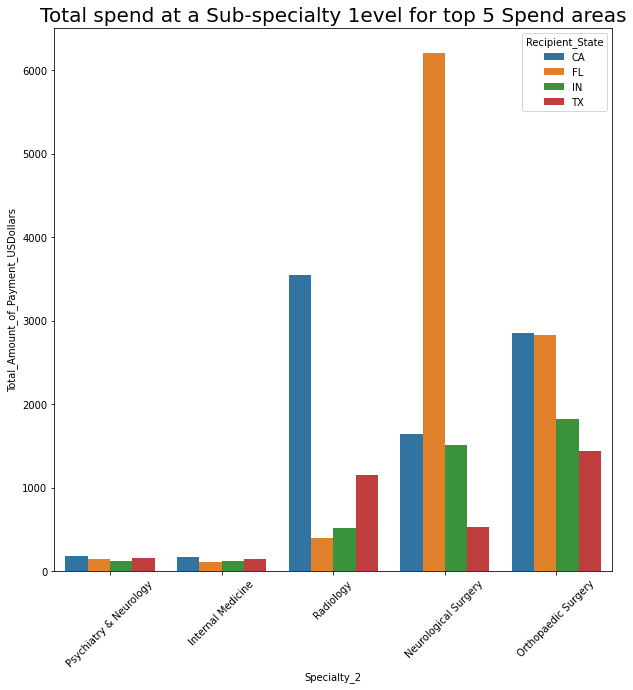

In [36]:
top_5_subspecialty = ['Orthopaedic Surgery','Internal Medicine','Neurological Surgery','Radiology','Psychiatry & Neurology']
amount_specialty_2 = df[df['Specialty_2'].isin(top_5_subspecialty)]

fig, ax = plt.subplots()
plt.xticks(rotation=45)

sns.barplot(data=amount_specialty_2, x='Specialty_2', y= 'Total_Amount_of_Payment_USDollars', hue ='Recipient_State', ci=None)

fig.set_size_inches(10,10)
plt.title('Total spend at a Sub-specialty 1evel for top 5 Spend areas',fontsize=20)

## Time Series of Tier 1 Specialties Across the Year 2020

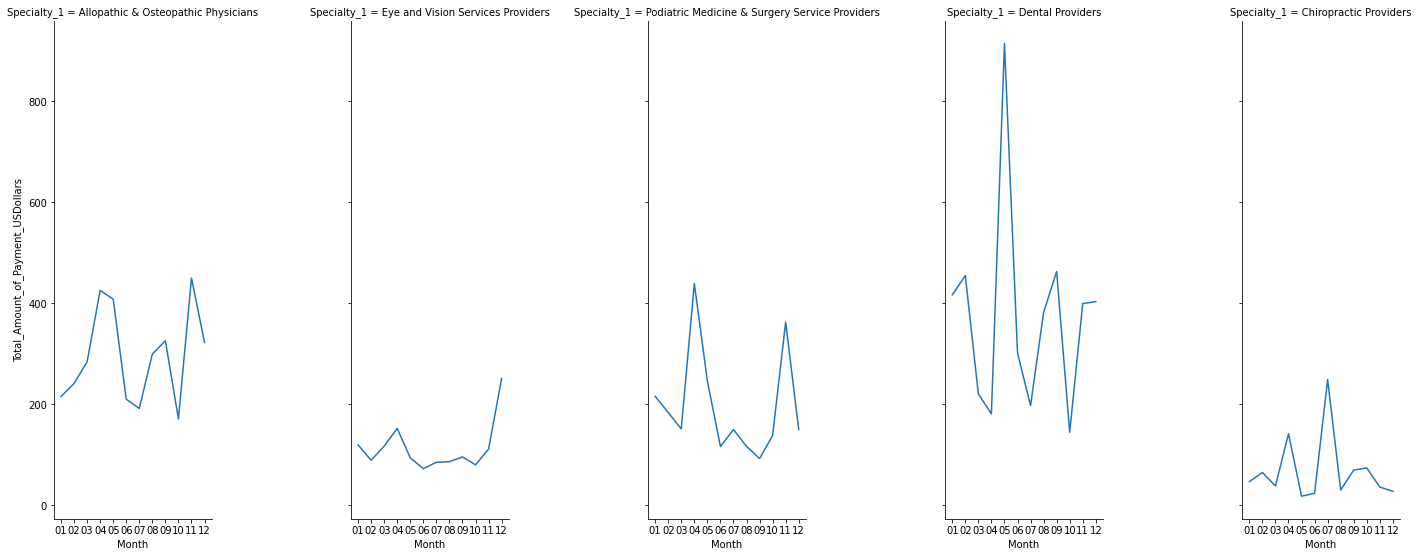

In [37]:
g = sns.FacetGrid(df.sort_values('Month'), col='Specialty_1')
g = g.map(sns.lineplot, 'Month', 'Total_Amount_of_Payment_USDollars', ci=None).add_legend()
plt.gcf().set_size_inches(20,10)

Text(0.5, 1.0, 'Monthly spend at a Specialty 1evel across 4 states')

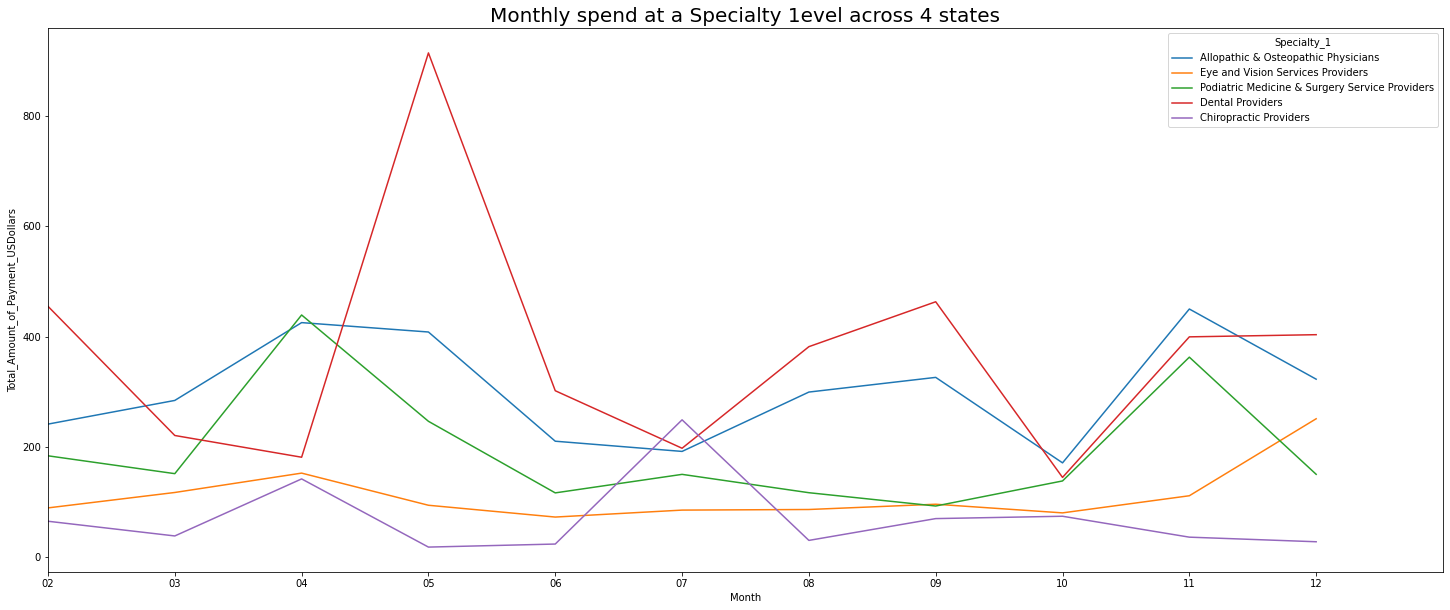

In [38]:
fig, ax = plt.subplots()

plt.xlim(1,12)
sns.lineplot(data=df.sort_values('Month'), x='Month', y='Total_Amount_of_Payment_USDollars', hue='Specialty_1', ci=None)

fig.set_size_inches(25,10)
plt.title('Monthly spend at a Specialty 1evel across 4 states',fontsize=20)

In [39]:
del df, amount_specialty_1, amount_specialty_2, amount_speciality_1, fig, f, g, s, w, x, y, ax, axs

## Physician Specialties Across 3 Years
The key Motivation in the following steps is to be able to analyse the total spend across multiple years at a Physician's Specialty level and Sub specialty level. This would give us visibility into the various speciality area level spend and provide guidance on the ones where the Pharma and instrumentation companies are spending the most.Also this would provide patterns of spend across years and will be a tool to understand spend trends across years.

In [40]:
cols = ['Physician_Specialty', 'Total_Amount_of_Payment_USDollars', 'Recipient_State', 'Date_of_Payment']
states = ['IN', 'FL', 'TX', 'CA']
df = df_from_csv_stream(cols, states=states)
df = df.append(df_from_csv_stream(cols, year=19, states=states))
df = df.append(df_from_csv_stream(cols, year=18, states=states))
df[['Specialty_1', 'Specialty_2', 'Specialty_3']] = df['Physician_Specialty'].str.split('|', expand=True)
df[['Month', 'Day', 'Year']] = df["Date_of_Payment"].str.split('/', expand=True)

Processing file: OP_DTL_GNRL_PGYR2020_P06302021.csv
Processed 1000000 rows.
Processed 2000000 rows.
Processed 3000000 rows.
Processed 4000000 rows.
Processed 5000000 rows.
Processed 6000000 rows.
Processing file: OP_DTL_GNRL_PGYR2019_P06302021.csv
Processed 1000000 rows.
Processed 2000000 rows.
Processed 3000000 rows.
Processed 4000000 rows.
Processed 5000000 rows.
Processed 6000000 rows.
Processed 7000000 rows.
Processed 8000000 rows.
Processed 9000000 rows.
Processed 10000000 rows.
Processed 11000000 rows.
Processing file: OP_DTL_GNRL_PGYR2018_P06302021.csv
Processed 1000000 rows.
Processed 2000000 rows.
Processed 3000000 rows.
Processed 4000000 rows.
Processed 5000000 rows.
Processed 6000000 rows.
Processed 7000000 rows.
Processed 8000000 rows.
Processed 9000000 rows.
Processed 10000000 rows.
Processed 11000000 rows.


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

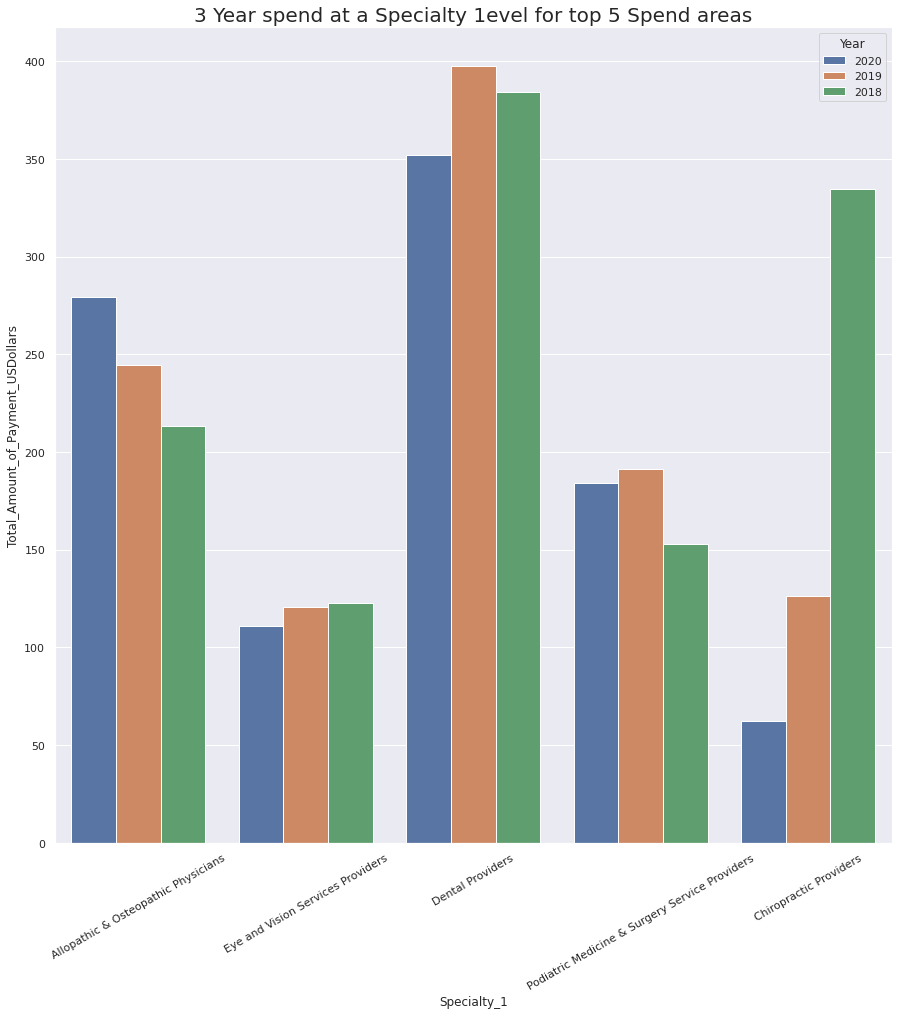

In [41]:
sns.set(rc = {'figure.figsize':(15,15)})
sns.barplot(data=df, x='Specialty_1', y='Total_Amount_of_Payment_USDollars', hue='Year', ci=None)

plt.title('3 Year spend at a Specialty 1evel for top 5 Spend areas',fontsize=20)
plt.xticks(rotation=30)

Text(0.5, 1.0, '3 Year spend at a Sub-specialty level for top 5 Spend areas')

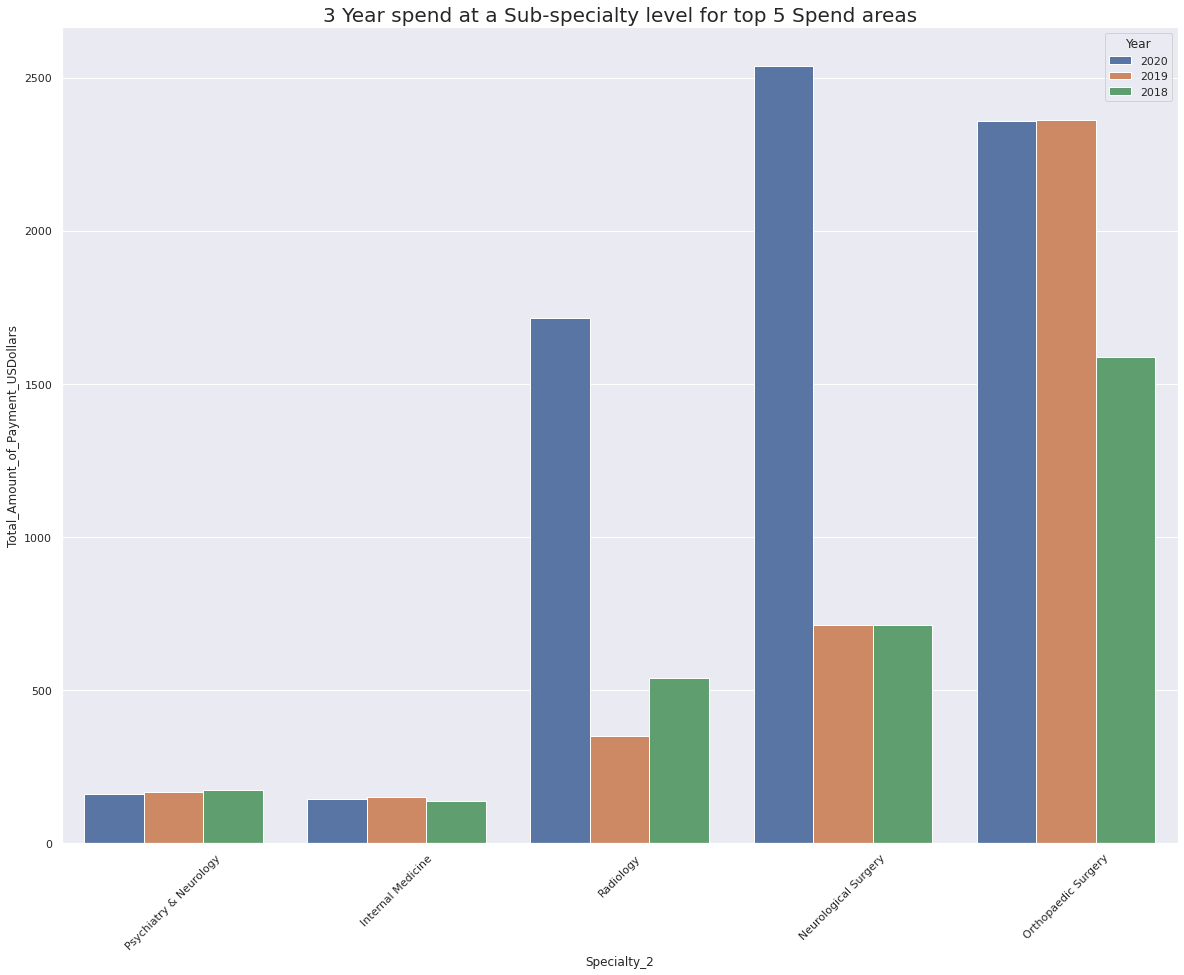

In [42]:
fig, ax = plt.subplots()
plt.xticks(rotation=45)
df = df[df['Specialty_2'].isin(top_5_subspecialty)]
sns.barplot(data=df, x='Specialty_2', y='Total_Amount_of_Payment_USDollars', hue='Year', ci=None)

fig.set_size_inches(20,15)
plt.title('3 Year spend at a Sub-specialty level for top 5 Spend areas',fontsize=20)

In [43]:
del df, top_5_subspecialty, states, fig, Top3

# Heatmap Analyzing Cross State Spending Patterns
The key Motivation in the following steps is to be able to analyse the major spend across states . The investment across Payer State(the states where the Pharma/Manufacturing company is located) and the state of the physicians is being analyzed.

In [44]:
cols = ['Recipient_State','Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State', 'Total_Amount_of_Payment_USDollars']
df = df_from_csv_stream(cols)

Processing file: OP_DTL_GNRL_PGYR2020_P06302021.csv
Processed 1000000 rows.
Processed 2000000 rows.
Processed 3000000 rows.
Processed 4000000 rows.
Processed 5000000 rows.
Processed 6000000 rows.


In [45]:
cms_2020_GP_CF = df.groupby(['Recipient_State','Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State']).agg(
     Total_Amount_USD = ('Total_Amount_of_Payment_USDollars','sum'),
     ).reset_index()
cms_2020_GP_CF.rename(columns={'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State' : 'Payer State'},inplace = True)
cms_2020_GP_CF.sort_values(by='Total_Amount_USD',ascending=False)
cms_2020_GP_1M = cms_2020_GP_CF[cms_2020_GP_CF['Total_Amount_USD'] > 1000000]
del cms_2020_GP_CF

Text(0.5, 1.0, 'Payment Analysis by Manaufacturer State for 2020')

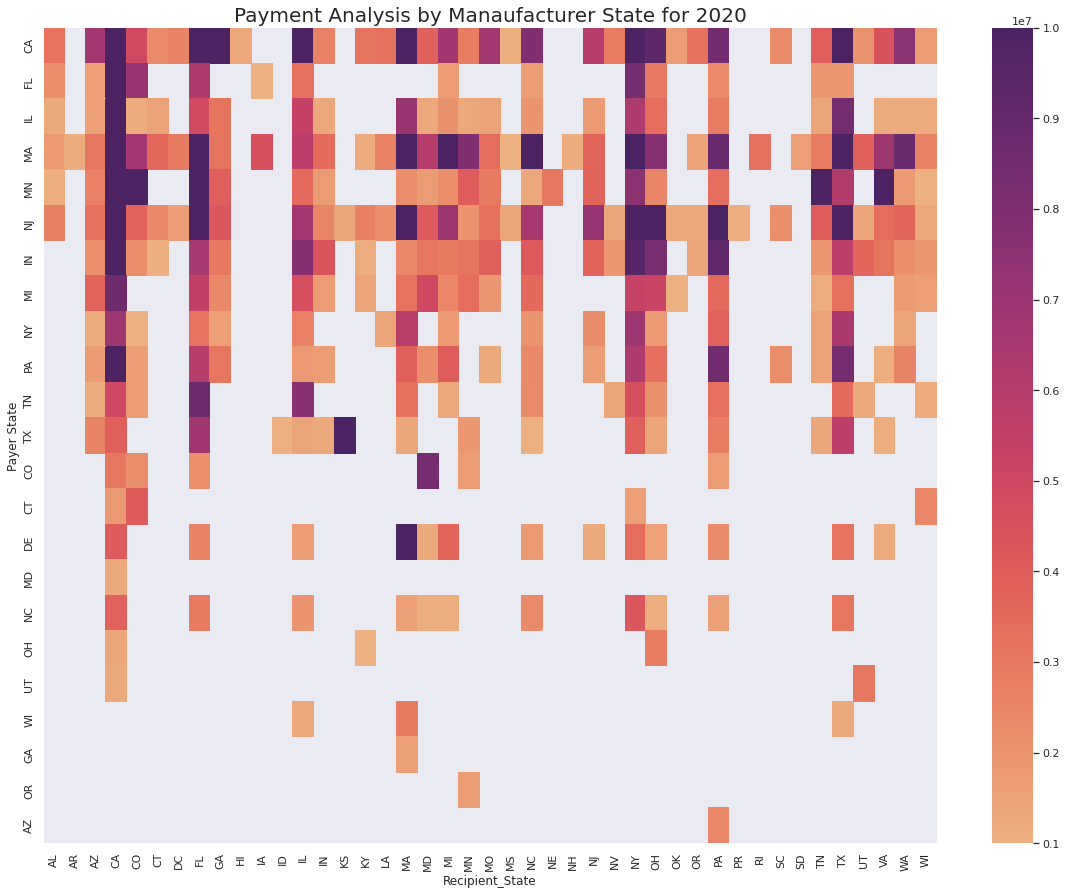

In [46]:
fig, ax = plt.subplots()

pivot = cms_2020_GP_1M.pivot(index='Payer State', columns='Recipient_State', values='Total_Amount_USD')

ax = sns.heatmap(pivot,vmin = 1000000, vmax = 10000000,cmap="flare")

fig.set_size_inches(20,15)

plt.title('Payment Analysis by Manaufacturer State for 2020',fontsize=20)

# Wordcloud on the Open Payments Research Dataset
The key Motivation in the following steps is to be able to analyse the key areas of "Research" being invested on as reported by CMS data. This is difficult to arrive at , as there is no direct field which can be queried for this. Hence a Word Cloud approach was adopted for this analysis.

In [47]:
cols = ['Name_of_Study']
df = df_from_csv_stream(cols, year=0)

Processing file: OP_DTL_RSRCH_PGYR2020_P06302021.csv
Processed 1000000 rows.


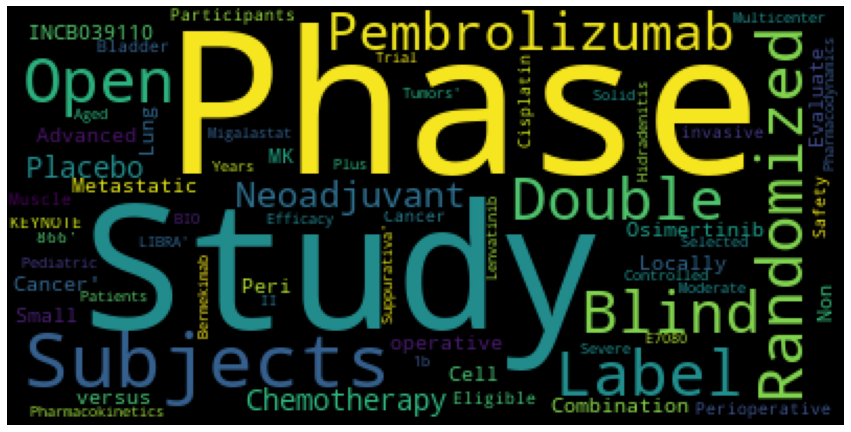

In [48]:
text = df["Name_of_Study"].values

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

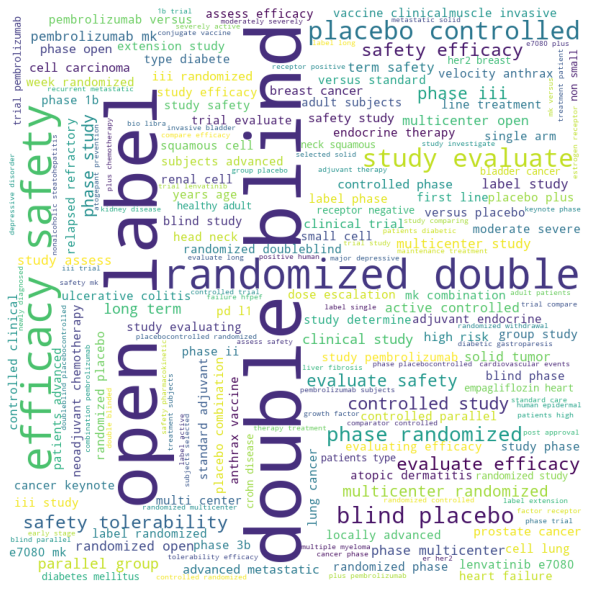

In [49]:
comment_words = ''
for val in df.Name_of_Study:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show() 

In [50]:
del comment_words, text, val, tokens, wordcloud